<a href="https://colab.research.google.com/github/flaviohds/MVP_Vendas_Analise/blob/main/analise_vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tempo aproximado de execução do notebook: um minuto.

---
---
# <center>Descrição do MVP
---

MVP feito para a *sprint* de **Análise de Dados e Boas Práticas** do MBA em **Ciencia de Dados e Analytics** pela PUC-rio
*   Autor: **Flávio Horsth De Seta**. 
*   Projeto disponível em https://github.com/flaviohds/MVP_Vendas_Analise .
*   Dataset retirado de https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting , acesso em 04/2023. 9800 observações e 18 colunas.
*   Descrição dos atributos:
 * Row ID - identificador da compra (numérico, inteiro)
 * Order ID - identificador do pedido (texto, categórico nominal)
 * Order Date - data do pedido (data)
 * Ship Date - data do envio (data)
 * Ship Mode - modo do envio (texto, categórico nominal)
 * Customer ID - identificador do cliente (texto, categórico nominal)
 * Segment - tipo de cliente (texto, categórico nominal)
 * Country - país do local de entrega (texto, categórico nominal)
 * City - cidade do local de entrega (texto, categórico nominal)
 * State - estado do local de entrega (texto, categórico nominal)
 * Postal Code - código postal do local de entrega (numérico, inteiro*)
 * Region - região do país do local de entrega (texto, categórico nominal)
 * Product ID - identificador do produto (texto, categórico nominal)
 * Category - categoria do produto (texto, categórico nominal)
 * Sub-Category - subcategoria do produto (texto, categórico nominal)
 * Product Name - nome do produto (texto, categórico nominal)
 * Sales - valor que o produto foi vendido (numérico, contínuo)

  \*   *O código postal utilizado é o código de cinco dígitos dos Estados Unidos. No dataset, quando ele aparece com menos de cinco dígitos é porque ele começa com um ou mais zeros. Os códigos poderiam ser convertidos para string para permitir 0 nos primeiros dígitos, mas seria perdida a relação numérica entre os eles.*

---
# <center> Descrição do problema e proposta
---


Nos dias atuais, muitas empresas têm interesse em estimar vendas diárias ou mensais, a fim de balancear gastos, lucros e metas. Este MVP tem como objetivo entender comportamento e padrões de compra de uma empresa que vende para os Estados Unidos, além de preparar os dados para uma futura implementação de *machine learning*. A ideia é obter *insights* sobre a variação diária das vendas da empresa e preparar os dados para um modelo que consiga prevê-las. Logo, o foco deste projeto é o perfil de vendas por dia.

O modelo proposto de aprendizado de máquina será de tipo supervisionado de regressão. Mais especificamente, será um modelo de previsão de série temporal. O modelo, a partir das vendas diárias, deve prever a soma do valor das vendas até 7 dias no futuro. Ressalta-se que a construção do modelo em si não faz parte do escopo deste MVP, apenas a análise e preparação dos dados.

O dataset escolhido contém os dados de um site que vende eletrônicos, mobília e material de escritório, focando em materiais para empresas ou para trabalho à distância. Cada linha representa uma compra de produto e contém informações do pedido, do consumidor, do local, do produto e o valor que o produto foi vendido. Porém, para o problema de *machine learning* citado, o dataframe preparado para o modelo será o agrupamento dessas vendas por dia.

Considerando as características do dataset, espera-se que as vendas estejam concentradas em metrópoles. Também se espera que tenhamos picos de vendas em feriados e que exista certa sazonalidade na distribuição das vendas ao longo dos anos.

O notebook será dividido em cinco partes: 

1.   Carregamento do dataset e identificação de problemas (análise inicial)
2.   Tratamento dos problemas identificados e adição de colunas auxiliares (tratamento dos dados)
3.   Análise mais profunda e extesa dos dados (análise exploratória)
4.   Tratamento do dataframe visando implementeção de *machine learning* (pré-processamento)
5.   Conclusão

Optou-se separar o tratamento para a análise exploratória e o pré-processamento para o machine learning porque se espera que a análise exploratória ajude a entender melhor a importância das variáveis frente à nossa variável de saída.

---
# Preparação do ambiente

In [1]:
import pandas as pd                                   # Para manipular dataframes
import matplotlib.pyplot as plt                       # Para confecção de gráficos
import seaborn as sns                                 # Para confecção de gráficos
import numpy as np                                    # Para acessar constantes matemáticas
import datetime                                       # Para manipular datas
import holidays                                       # Para acessar datas de feriados
import importlib                                      # Para resetar configurações
from matplotlib.lines import Line2D                   # Para criar legendas customizadas
from IPython.display import Image                     # Para reproduzir imagens
from statsmodels.graphics.tsaplots import plot_acf    # Para plotar correlação com lag
from sklearn.model_selection import train_test_split  # Para particionar dados
from sklearn.preprocessing import MinMaxScaler        # Para normalizar dados


sns.set_theme()                                       # Para estilizar os gráficos

In [2]:
#move uma coluna de um dataframe
def mover_coluna(dataframe, nome_coluna: str, posicao: int):
  coluna = dataframe.pop(nome_coluna)
  dataframe = dataframe.insert(posicao, coluna.name, coluna)

---
# <center>1 - Análise inicial do dataset
---


Nesta seção o dataset é carregado e é feita uma investigação inicial dos possíveis problemas a serem tratados na sessão de Tratamento de dados, antes de ser feita a análise exploratória.

Para começar, importa-se o dataset do repositório do github. Como o primeiro atributo é apenas um identificador sequencial, esta coluna será utilizada como índice.

In [3]:
url = 'https://raw.githubusercontent.com/flaviohds/MVP_Vendas_Analise/main/superstore_sales.csv'
df_raw = pd.read_csv(url, index_col=0)
df_raw

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.7980
9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880


In [4]:
df_raw.describe()

,Postal Code,Sales
count,9789.000000,9800.000000
mean,55273.322403,230.769059
std,32041.223413,626.651875
min,1040.000000,0.444000
25%,23223.000000,17.248000
50%,58103.000000,54.490000
75%,90008.000000,210.605000
max,99301.000000,22638.480000


Dataset importado e carregado com sucesso. Número de colunas e linhas corretos de acordo com a [fonte](https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting). Valores dos atributos na amostra acima aparentam estar de acordo com a descrição inicial dos atributos. Valores mínimo e máximo das vendas dentro do aceitável, apesar de haver uma grande variação nos valores das vendas. Valor máximo do código postal não ultrapassa os 5 dígitos.

Notam-se algumas irregularidades nas colunas de:

*   Order date e Ship date
*   Country
*   Postal Code
*   Sales

---
## 1.1 - Colunas de datas

Quando se importa datas diretamente de um csv, a biblioteca pandas atribui os valores ao tipo string ou ao tipo de objeto genérico, como pode ser observado abaixo. Esse fato dificulta a manipulação e visualização dos dados de datas.

In [5]:
type(df_raw['Order Date'][1])

str

---
## 1.2 - Coluna de país

Na amostra inicial do dataset nota-se que o único país exibido é os Estados Unidos.

In [6]:
df_raw['Country'].unique()

array(['United States'], dtype=object)

De fato, este dataset apresenta **apenas** vendas dos Estados Unidos, ou seja, esta coluna é desnecessária.

---
##1.3 - Coluna de código postal

Os valores de código postal apresentam uma casa decimal, o que não é normal no código postal de 5 dígitos dos Estados Unidos. Surge a suspeita de que alguma observação foi importada com casa decimal na coluna Postal Code, o que pode indicar agum erro quando o dataset foi carregado. A fim de estudar essas linhas, procura-se se existe algum código postal não-inteiro.

In [7]:
# Retorna as linhas que quando o código postal é dividido o resto é diferente de 0
df_raw[(df_raw['Postal Code']) % 1 != 0]

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,
2235,CA-2018-104066,05/12/2018,10/12/2018,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5275,CA-2016-162887,07/11/2016,09/11/2016,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8799,US-2017-150140,06/04/2017,10/04/2017,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9147,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9148,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9149,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9387,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9388,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9389,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94


Dois fatos ficam evidentes aqui:
*   Existem valores faltantes na coluna de código postal
*   Os únicos valores não inteiros de códigos postais são os valores NaN, indicando que não houve erros ao importar a coluna e os valores estão de acordo com a lista de atributos.




---
## 1.4 - Valores faltantes

Já foi observado que existem valores faltantes (representados como NaN no dataframe), na coluna de código postal. Verificando todos os valores faltantes do dataframe notamos que todos os valores faltantes acima são referentes a Burlington-Vermont:

In [8]:
df_raw[df_raw.isnull().any(axis=1)]

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,
2235,CA-2018-104066,05/12/2018,10/12/2018,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5275,CA-2016-162887,07/11/2016,09/11/2016,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8799,US-2017-150140,06/04/2017,10/04/2017,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9147,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9148,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9149,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9387,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9388,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9389,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94


Como o dataset acima é igual ao anterior, conclui-se que todos os dados faltantes são os de códigos postais da cidade de Burlington e estado de Vermont.

---
## 1.5 - Coluna de vendas

O valor das vendas apresenta mais de duas casas decimais, algo incomum para valores monetários. Após uma breve pesquisa de datasets semelhantes (por exemplo, os datasets de [vendas da amazon](https://www.kaggle.com/datasets/lokeshparab/amazon-products-dataset) e [vendas de supermercado](https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales)), nota-se que é comum incluir o valor de impostos e descontos percentuais no valor das vendas, resultando em várias casas decimais nos valores na coluna. Como nem o desconto, nem os impostos são fornecidos, ou mesmo relevantes para a análise em questão, não há necessidade de tratamento desta coluna.

---
## 1.6 - Produtos repetidos

Além dos problemas citados acima existe uma análise que deve ser feita para melhor entendimento do dataset. Não foi especificado na fonte (e também não fica imediatamente claro ao olhar para o dataset) se, caso sejam comprados dois produtos idênticos no mesmo pedido, o dataset mostraria duas linhas diferentes para o mesmo produto, ou se os dois produtos seriam agregados numa mesma linha e o valor em `Sales` somado. 

Para verificar como o dataset trata esses produtos repetidos, se realiza uma varredura no dataset, olhando para cada ID de pedido e procurando por produtos duplicados.

In [9]:
# Inicializa a lista vazia de produtos repetidos
IDpedidos_produto_repetido = []                           

# Filtra o dataset pelo ID do pedido da iteração
for i in df_raw['Order ID'].unique():                     
  df_order = df_raw[df_raw['Order ID'] == i]     
  
  # Se existir duplicatas de algum produto no pedido iterado, adiciona o ID do pedido à lista
  if (True in df_order.duplicated('Product ID').tolist()):
    IDpedidos_produto_repetido.append(i)

# Mostra a lista de ID de pedidos que contém produto repetido
IDpedidos_produto_repetido                                

['CA-2017-129714',
 'US-2017-123750',
 'CA-2017-137043',
 'CA-2018-152912',
 'US-2015-150119',
 'CA-2016-103135',
 'CA-2018-118017',
 'CA-2017-140571']

Como a lista retornada não está vazia, o dataset trata múltiplas unidades do mesmo produto em um pedido como mais de uma linha. Por exemplo, o pedido a seguir contém dois produtos iguais.

In [10]:
df_raw[df_raw['Order ID'] == 'CA-2017-137043']

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,
1301,CA-2017-137043,23/12/2017,25/12/2017,Second Class,LC-17140,Logan Currie,Consumer,United States,Springfield,Virginia,22153.0,South,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",572.76
1302,CA-2017-137043,23/12/2017,25/12/2017,Second Class,LC-17140,Logan Currie,Consumer,United States,Springfield,Virginia,22153.0,South,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",286.38


Nota-se também que os dois produtos, apesar de serem iguais, foram comprados por preços diferentes. O motivo desse comportamento do dataset não é explicado na fonte, mas pode ser o modo que a loja tem de tratar internamente descontos ao levar múltiplos produtos iguais. De qualquer forma este comportamento não interfere nos planos deste MVP.

---
# <center>2 - Tratamento dos dados
---

Nessa seção serão tratadas as irregularidades evidentes na análise inicial, a fim de resolver os problemas que atrapalhariam a análise exploratória. Também serão criadas algumas colunas que facilitarão a análise da seção seguinte.

Começa-se criando uma cópia dos dados para podermos acessar os originais rapidamente se necessário.

In [11]:
df = df_raw.copy()

---
## 2.1 - Removendo colunas desnecessárias

Como foi visto na seção anterior, a coluna `Country` só possui 1 valor possível, já que todas as vendas são dos Estados Unidos.

Além disso, se observarmos as colunas de `Customer ID` e `Customer Name`, é fácil perceber que elas são redundantes, então podemos remover uma delas. Não só isso, utilizar o nome do comprador em uma análise (por exemplo, verificar compradores que retornaram e fizeram mais de um pedido) pode gerar erros já que o nome pode não ser único para dois compradores diferentes. Logo, remove-se a coluna de nome do consumidor.

In [12]:
df.drop(columns = 'Country', inplace=True)
df.drop(columns = 'Customer Name', inplace=True)
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Corporate,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


---
## 2.2 - Convertendo as datas

A fim de facilitar a manipulação e interpretação dos dados de datas, as colunas `Order Date` e `Ship Date` serão convertidas para o formato correto.



In [13]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Corporate,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Agora podemos plotar e fazer operações com essas colunas. Por exemplo:

In [14]:
print('Dia do pedido:   ' + str(df['Order Date'][1]))
print('Dia do envio:    ' + str(df['Ship Date'][1]))
print('Atraso do envio: ' + str(df['Ship Date'][1] - df['Order Date'][1]))

Dia do pedido:   2017-11-08 00:00:00
Dia do envio:    2017-11-11 00:00:00
Atraso do envio: 3 days 00:00:00


---
## 2.3 - Tratando os códigos postais faltantes

Como foi visto na análise inicial, alguns códigos postais estão sem registro. Todos eles eram da cidade de Burlington e do estado de Vermont. A ideia inicial é pegar o código postal de uma observação do dataframe com mesma cidade e estado.

In [15]:
# Parte do dataframe que pertence a cidade de Burlington e estado de Vermont
df_VB = df[(df['City'] == 'Burlington') & (df['State'] == 'Vermont')]
df_VB

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,
2235,CA-2018-104066,2018-12-05,2018-12-10,Standard Class,QJ-19255,Corporate,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5275,CA-2016-162887,2016-11-07,2016-11-09,Second Class,SV-20785,Consumer,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8799,US-2017-150140,2017-04-06,2017-04-10,Standard Class,VM-21685,Home Office,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9147,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Corporate,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9148,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Corporate,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9149,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Corporate,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9387,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Consumer,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9388,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Consumer,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9389,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Consumer,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94


Nota-se que todos os códigos das compras da cidade de Burlington de Vermont estão faltantes. Será necessário pesquisar códigos postais comuns desse local em uma fonte externa.

De acordo com https://www.zip-codes.com/city/vt-burlington.asp (acesso em 04/2023) são 3 os códigos postais relevantes e suas populações percentuais:

1.   05401 - 66,00%
2.   05408 - 23,68%
3.   05405 - 10,32%



A ideia é popular os códigos postais faltantes com uma proporção similar à população percentual acima. Porém, se observarmos o dataframe de Burlington, Vermont `df_VB` acima, não faz sentido substituir os valores às cegas, já que algumas linhas pertencem ao mesmo comprador (que, logicamente, teriam o mesmo código postal). Logo, é necessário balancear fidelidade à proporção populacional com as limitações do dataset.

Tentando aproximar a proporção do número de produtos com a população em cada código postal:

In [16]:
print('Dados do dataset da cidade de Burlington e estado de Vermont:')
print(str(df_VB.shape[0])+' linhas, ' +
      str(df_VB['Order ID'].unique().size) + ' pedidos diferentes')
print('Cada pedido é composto pelo seguinte número de produtos:')
df_VB['Order ID'].value_counts().tolist()

Dados do dataset da cidade de Burlington e estado de Vermont:
11 linhas, 6 pedidos diferentes
Cada pedido é composto pelo seguinte número de produtos:


[4, 3, 1, 1, 1, 1]

In [17]:
grupo1=7/11  # Pedidos -> 4+1+1+1=7
grupo2=3/11  # Pedidos -> 3
grupo3=1/11  # Pedidos -> 1
print('Percentual de produtos do grupo 1: %.4f'%grupo1)
print('Percentual de produtos do grupo 2: %.4f'%grupo2)
print('Percentual de produtos do grupo 3: %.4f'%grupo3)

Percentual de produtos do grupo 1: 0.6364
Percentual de produtos do grupo 2: 0.2727
Percentual de produtos do grupo 3: 0.0909


Utilizando os grupos acima atingimos as proporções:
*   63,64% ≈ 66,00% → 05401
*   27,27% ≈ 23,68% → 05408
*   9,09% ≈ 10,32% → 05405

***OBS***: Como foi dito na descrição dos atributos, os códigos postais iniciados com 0 ficam com menos dígitos no dataframe para manter a relação númerica entre si (o que não aconteceria se transformássemos em string, por exemplo).

Observando o dataframe anterior é possível chegar ao vetor de códigos postais:

[5401, 5401, 5401, 5408, 5408, 5408, 5401, 5401, 5401, 5401, 5405]

In [18]:
vetor_substituicao = [5401, 5401, 5401, 5408, 5408, 5408,
                      5401, 5401, 5401, 5401, 5405]

# Substitui os valores nulos pelos elementos do vetor de substituição
df.loc[df['Postal Code'].isnull(), 'Postal Code'] = vetor_substituicao
df[(df['City'] == 'Burlington') & (df['State'] == 'Vermont')]

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,
2235,CA-2018-104066,2018-12-05,2018-12-10,Standard Class,QJ-19255,Corporate,Burlington,Vermont,5401.0,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5275,CA-2016-162887,2016-11-07,2016-11-09,Second Class,SV-20785,Consumer,Burlington,Vermont,5401.0,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8799,US-2017-150140,2017-04-06,2017-04-10,Standard Class,VM-21685,Home Office,Burlington,Vermont,5401.0,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9147,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Corporate,Burlington,Vermont,5408.0,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9148,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Corporate,Burlington,Vermont,5408.0,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9149,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Corporate,Burlington,Vermont,5408.0,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9387,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Consumer,Burlington,Vermont,5401.0,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9388,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Consumer,Burlington,Vermont,5401.0,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9389,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Consumer,Burlington,Vermont,5401.0,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94


Note que os códigos postais se mantém iguais entre de linhas do mesmo pedido.

Para finalizar, convertemos os códigos postais para inteiros. Deixaremos a coluna mais limpa e utilizamos menos memória sem perda de informação.

In [19]:
df['Postal Code']=df['Postal Code'].astype(int)

---
## 2.4 - Coluna de cidade

Se observarmos a coluna de cidade, podemos notar um possível problema para a nossa análise. Algo natural de se fazer ao estudar o dataset é verificar quantas vezes cada valor se repete em sua coluna para observar qual o valor mais comum. Por exemplo, se soubermos quais cidades mais se repetem na devida coluna, conseguimos aprender mais sobre cidades que compraram mais produtos. Porém, como existem cidades em estados diferentes com o mesmo nome, acabaríamos coletando informações falsas. Podemos ver esse caso se procurarmos pela cidade de Burlington, como fizemos acima, mas sem especificar o estado:

In [20]:
df[df['City']=='Burlington'].head(4)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,
684,US-2018-168116,2018-11-04,2018-11-04,Same Day,GT-14635,Corporate,Burlington,North Carolina,27217,South,TEC-MA-10004125,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980
685,US-2018-168116,2018-11-04,2018-11-04,Same Day,GT-14635,Corporate,Burlington,North Carolina,27217,South,OFF-AP-10002457,Office Supplies,Appliances,Eureka The Boss Plus 12-Amp Hard Box Upright V...,167.440
1009,US-2018-106705,2018-12-26,2019-01-01,Standard Class,PO-18850,Consumer,Burlington,Iowa,52601,Central,OFF-PA-10001509,Office Supplies,Paper,"Recycled Desk Saver Line ""While You Were Out"" ...",44.750
1039,CA-2018-121818,2018-11-20,2018-11-21,First Class,JH-15430,Consumer,Burlington,North Carolina,27217,South,OFF-AR-10000203,Office Supplies,Art,Newell 336,23.968


Note que a coluna de cidade consta 'Burlington' em todas as linhas, apesar de ser dois estados diferentes, além do estado de Vermont já visto anteriormente.

A fim de facilitar a análise exploratória, a coluna de cidade será modificada ao se adicionar o estado de onde ela se encontra. Como não existem duas cidades com nomes iguais no mesmo estado, resolveremos o problema citado.

In [21]:
# Concatena a cidade com o estado e substitui no campo de cidade
df['City'] = df['City'] + ', ' + df['State']
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Corporate,"Los Angeles, California",California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Apesar de adicionarmos redundância no dataframe, resolvemos o problema de duplicidade.

---
## 2.5 - Criando a coluna de atraso de envio

Considerando que temos a data da compra e a data do envio, será interessante analisar o tempo que o produto levou para sair do fornecedor.

In [22]:
df['Ship Delay'] = df['Ship Date'] - df['Order Date']
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Ship Delay
Row ID,,,,,,,,,,,,,,,,
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,3 days
2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3 days
3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Corporate,"Los Angeles, California",California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,4 days
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,7 days
5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,7 days


Coluna de `Ship Delay` adicionada. Retirando a parte da string que diz ' days' e transformando o atributo para o tipo inteiro:

In [23]:
# Transforma em str, remove o sufixo ' days' e converte para int no final
df['Ship Delay'] = df['Ship Delay'].astype(str).replace(r' days', r'', 
                                                        regex=True).astype(int)
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Ship Delay
Row ID,,,,,,,,,,,,,,,,
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,3
2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3
3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Corporate,"Los Angeles, California",California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,4
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,7
5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,7


Conferindo se a coluna foi convertida para inteiro:

In [24]:
type(df['Ship Delay'][1])

numpy.int64

---
## 2.6 - Criando a coluna de dia da semana do pedido

Será interessante saber se as compras variam de acordo com o dia da semana. Como já temos a data do pedido, cria-se a coluna do dia da semana em que o pedido foi efetivado.

In [25]:
df['Order Weekday'] = df['Order Date'].dt.day_name()
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Ship Delay,Order Weekday
Row ID,,,,,,,,,,,,,,,,,
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,3,Wednesday
2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,Wednesday
3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Corporate,"Los Angeles, California",California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,4,Monday
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,7,Tuesday
5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,7,Tuesday


---
## 2.7 - Criando coluna de feriados

Também espera-se que os dias de feriado afetem as vendas. Para carregar os feriados com a biblioteca `holidays`, é primeiro necessário saber qual o intervalo de datas que o nosso dataframe se encontra.

In [26]:
print('primeiro pedido: ' + str(min(df['Order Date'])))
print('último pedido: ' + str(max(df['Order Date'])))

primeiro pedido: 2015-01-03 00:00:00
último pedido: 2018-12-30 00:00:00


In [27]:
# Armazena todas os feriados dos anos especificados
us_holidays = holidays.UnitedStates(years=[2015, 2016, 2017, 2018])

Agora criamos uma coluna que diz se a data é feriado ou não ao comparar a data do pedido com a lista de feriados.

In [28]:
# Verifica se a data de cada linha é coincide com um feriado
df['Is Holiday'] = df['Order Date'].isin(us_holidays)
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Ship Delay,Order Weekday,Is Holiday
Row ID,,,,,,,,,,,,,,,,,,
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,3,Wednesday,False
2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,Wednesday,False
3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Corporate,"Los Angeles, California",California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,4,Monday,False
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,7,Tuesday,False
5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,7,Tuesday,False


---
## 2.8 - Reordenando as colunas

Para mais fácil visualização é interessante colocar as novas colunas relativas a datas e envio próximas das colunas semelhantes.

In [29]:
mover_coluna(df, 'Ship Delay', 3)
mover_coluna(df, 'Is Holiday', 2)
mover_coluna(df, 'Order Weekday', 2)

In [30]:
df.head(1)

,Order ID,Order Date,Order Weekday,Is Holiday,Ship Date,Ship Delay,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,,
1,CA-2017-152156,2017-11-08,Wednesday,False,2017-11-11,3,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96


Todas as colunas agora estão agrupadas por assunto: pedido, datas, envio, consumidor, local, produto e vendas.

---
# <center>3 - Análise Exploratória
---


Essa seção tem como objetivo explorar os dados a fim de descrever as variáveis, seus comportamentos e suas interações. Apesar do objetivo final ser obter insights para o problema proposto, também serão apresentados comportamentos inicialmente irrelevantes ao problema de *machine learning*. Estes comportamentos podem se tornar relevantes para a preparação de dados para o modelo. Esses comportamentos também podem resultar em insights de *business intelligence*, como o focar o marketing da empresa em certa região ou em certo produto.

Agora que nosso dataframe está tratado, podemos começar a retirar mais informações sobre o comportamento das variáveis. Antes de tudo, vamos observar como ficou a estrutura do nosso dataframe tratado.

In [31]:
df.head()

,Order ID,Order Date,Order Weekday,Is Holiday,Ship Date,Ship Delay,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,,
1,CA-2017-152156,2017-11-08,Wednesday,False,2017-11-11,3,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2,CA-2017-152156,2017-11-08,Wednesday,False,2017-11-11,3,Second Class,CG-12520,Consumer,"Henderson, Kentucky",Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
3,CA-2017-138688,2017-06-12,Monday,False,2017-06-16,4,Second Class,DV-13045,Corporate,"Los Angeles, California",California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
4,US-2016-108966,2016-10-11,Tuesday,False,2016-10-18,7,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
5,US-2016-108966,2016-10-11,Tuesday,False,2016-10-18,7,Standard Class,SO-20335,Consumer,"Fort Lauderdale, Florida",Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


---
## 3.1 - Análise individual das colunas

Na próxima subseção, será feito o agrupamento dos dados por data, que é o foco deste MVP. Porém, caso os dados fossem agrupados agora acabaríamos jogando informação fora. Com esses dados podemos observar comportamentos interessantes e até mesmo relevantes para a análise principal deste projeto. Logo, começaremos olhando para cada atributo do dataframe original `df` para entender quais valores são mais comuns ou sub-representados, assim como ter uma ideia de sua distribuição.

---
### Order ID

Olhando para a coluna de ID do pedido não é possível conseguir insights relevantes sobre o valor de cada observação já que se trata de um identificador, mas podemos descobrir quantos pedidos temos e qual o pedido com maior número de itens.

In [32]:
df['Order ID'].value_counts()

CA-2018-100111    14
CA-2018-157987    12
CA-2017-165330    11
US-2017-108504    11
CA-2017-105732    10
                  ..
US-2016-110261     1
CA-2016-125710     1
US-2016-137960     1
CA-2016-124975     1
CA-2016-142202     1
Name: Order ID, Length: 4922, dtype: int64

In [33]:
print('média ' + str(df['Order ID'].value_counts().mean()))
print('mediana: ' + str(df['Order ID'].value_counts().median()))

média 1.991060544494108
mediana: 1.0


Temos 4922 pedidos que contém nossas 9800 compras de produtos. Podemos ver que o maior pedido tem 14 itens. Apesar disso, a média é 1,99 e a mediana é 1, indicando que grande parte dos pedidos possuem apenas um item.

Como o plot no histograma fica difícil de visualizar as raras ocorrências de pedidos com mais de 8 produtos, é plotado o gráfico da lista ordenada acima ao lado dele.

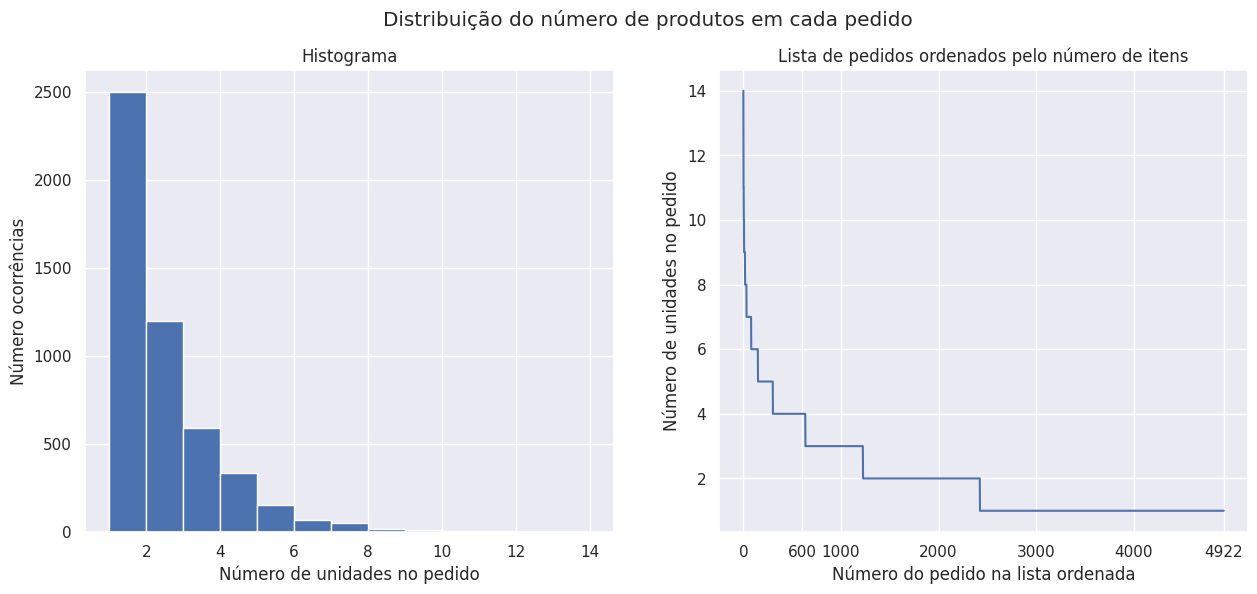

In [34]:
lista = df['Order ID'].value_counts().tolist()

fig2,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
fig2.suptitle('Distribuição do número de produtos em cada pedido')

ax1.hist(lista,bins=13)
ax1.set(xlabel='Número de unidades no pedido', ylabel='Número ocorrências',
        title='Histograma')


ax2.plot(lista)

ax2.set(xlabel='Número do pedido na lista ordenada',
        ylabel='Número de unidades no pedido',
        xticks=[0,600,1000,2000,3000,4000,4922],
        title='Lista de pedidos ordenados pelo número de itens')

plt.show()

De fato, podemos observar no gráfico à direita que apenas aproximadamente 600 dos 4922 pedidos tem mais de 3 itens.

---
### Order Date

Passamos agora para a coluna da data do pedido. Com a coluna convertida para o formato correto fica fácil obter informações. Por exemplo, a extensão das datas do dataframe e a distribuição da venda de produtos no tempo.

In [35]:
print('primeiro pedido:' + str(min(df['Order Date'])))
print('último pedido:' + str(max(df['Order Date'])))

primeiro pedido:2015-01-03 00:00:00
último pedido:2018-12-30 00:00:00


O dataframe se estende por 4 anos.

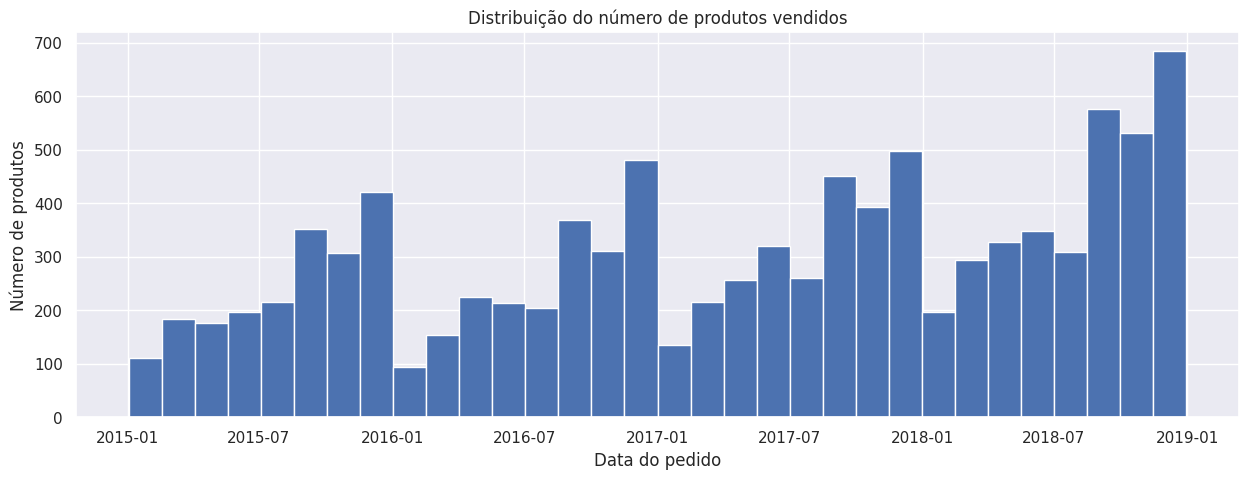

In [36]:
plt.figure(figsize=[15,5])

plt.hist(df['Order Date'],bins=32)

plt.title('Distribuição do número de produtos vendidos')
plt.xlabel('Data do pedido')
plt.ylabel('Número de produtos')

plt.show()

Começamos a ver uma tendência nas vendas, como o aumento considerável ao final do ano e um leve aumento da média ao longo dos anos também. É importante ressaltar que o gráfico acima representa o número de produtos vendidos, e não o valor somado das vendas de cada mês.

---
### Ship Mode e Ship Delay

Como as colunas de dia da semana, feriado e data de envio não são interessantes quando analisadas isoladamente, passamos direto para a coluna de atraso no envio e modo de envio.

In [37]:
df['Ship Mode'].value_counts()

Standard Class    5859
Second Class      1902
First Class       1501
Same Day           538
Name: Ship Mode, dtype: int64

Quatro tipos de envios diferentes, inclusive um de entrega no mesmo dia. Tipo de *Standard* compõe quase 60% das entregas dos produtos.

In [38]:
df['Ship Delay'].value_counts()

4    2718
5    2147
2    1295
6    1170
3     978
7     615
0     514
1     363
Name: Ship Delay, dtype: int64

0 a 7 dias entre a efetivação e o envio do pedido, com a grande maioria sendo entre 3 e 6 dias de atraso. É interessante observar que existe um número menor de pedidos com 0 dias de atraso do que pedidos com o tipo de entrega de *Same Day*, indicando que existem pedidos desse tipo que não foram entregues no mesmo dia. Esse fato provavelmente se deve a pedidos feitos no final ou fora do horário comercial, impossibilitando o envio imediato.

---
### Customer ID e Segment

Antes de começar o ID do consumidor é importante falar sobre a relação entre essa coluna e a coluna de ID do pedido vista no início da seção. Espera-se que a maior parte do ID de compra reflita o comportamento do ID do pedido, já que compras do mesmo pedido precisam ter o mesmo comprador. A única exceção a esta regra acontece quando temos compradores que retornaram. Logo, comparando o número de pedidos com o número de compradores, é possível ter uma ideia de quantos pedidos temos de compradores que retornaram.

In [39]:
df['Customer ID'].value_counts()

WB-21850    35
MA-17560    34
PP-18955    34
JL-15835    33
CK-12205    32
            ..
JR-15700     1
CJ-11875     1
SC-20845     1
RE-19405     1
AO-10810     1
Name: Customer ID, Length: 793, dtype: int64

Considerando que existem apenas 793 consumidores diferentes para 4922 pedidos, é fácil notar que grande parte dos pedidos são de consumidores que voltaram a comprar da loja.

Passando para a coluna `Segment` , podemos ver que tipos de consumidores são esses:

In [40]:
df['Segment'].value_counts()

Consumer       5101
Corporate      2953
Home Office    1746
Name: Segment, dtype: int64

Notamos que a maior parte dos produtos são comprados por pessoas físicas, com uma parte menor sendo para trabalho remoto.

---
### Atributos de local

Olhando agora para as colunas de local, podemos descobrir a região, o estado e a cidade que mais compraram produtos. Também é possível ser um pouco mais preciso se olharmos para o código postal mais comum.

In [41]:
df['Region'].value_counts()

West       3140
East       2785
Central    2277
South      1598
Name: Region, dtype: int64

In [42]:
df['State'].value_counts().head()

California      1946
New York        1097
Texas            973
Pennsylvania     582
Washington       504
Name: State, dtype: int64

In [43]:
df['State'].value_counts().tail()

District of Columbia    10
Maine                    8
North Dakota             7
West Virginia            4
Wyoming                  1
Name: State, dtype: int64

In [44]:
df['City'].value_counts()

New York City, New York       891
Los Angeles, California       728
Philadelphia, Pennsylvania    532
San Francisco, California     500
Seattle, Washington           426
                             ... 
Manhattan, Kansas               1
Rock Hill, South Carolina       1
Tinley Park, Illinois           1
Conroe, Texas                   1
Springdale, Arkansas            1
Name: City, Length: 600, dtype: int64

In [45]:
df['Postal Code'].value_counts().head(10)

10035    253
10024    225
10009    220
94122    195
10011    193
94110    166
98105    165
19134    160
90049    150
98103    149
Name: Postal Code, dtype: int64

As seguintes informações podem ser retiradas das saídas acima:

*   A região oeste tem o maior número de vendas. A maioria dos produtos vendidos dessa região é do estado da Califórnia, reponsável por mais de 60% de suas vendas, sendo o estado que mais vendeu.
*   A região com o segundo maior número de vendas é o leste, que contém o segundo estado com mais vendas, New York.
*   O estado com o menor número de compras é Wyoming, com um único produto comprado
*   Apesar da California ser o estado com maior número de produtos comprados, com quase o dobro do estado de New York, New York City é a cidade com mais produtos comprados.
*   New York City é responsável por 81% das compras do estado de New York.
*   4 dos 5 códigos postais com mais compras são de New York City.

Ou seja, apesar da Califórnia ser o estado com maior número de vendas, existe uma imensa concentração no estado de New York, mais específicamente, na cidade de New York City.


---
### Product ID

Passando para a coluna de ID do produto:

In [46]:
df['Product ID'].value_counts().head()

OFF-PA-10001970    19
TEC-AC-10003832    18
FUR-FU-10004270    16
TEC-AC-10002049    15
TEC-AC-10003628    15
Name: Product ID, dtype: int64

Buscando informações sobre o produto mais vendido:

In [47]:
IDproduto_mais_popular = df['Product ID'].value_counts().index[0]
df[df['Product ID'] == IDproduto_mais_popular].head()

,Order ID,Order Date,Order Weekday,Is Holiday,Ship Date,Ship Delay,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,,
351,CA-2017-129714,2017-09-01,Friday,False,2017-09-03,2,First Class,AB-10060,Home Office,"New York City, New York",New York,10009,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,24.560
353,CA-2017-129714,2017-09-01,Friday,False,2017-09-03,2,First Class,AB-10060,Home Office,"New York City, New York",New York,10009,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,49.120
412,CA-2018-117457,2018-12-08,Saturday,False,2018-12-12,4,Standard Class,KH-16510,Consumer,"San Francisco, California",California,94110,West,OFF-PA-10001970,Office Supplies,Paper,Xerox 1908,55.980
438,CA-2017-147375,2017-06-12,Monday,False,2017-06-14,2,Second Class,PO-19180,Home Office,"Chicago, Illinois",Illinois,60623,Central,OFF-PA-10001970,Office Supplies,Paper,Xerox 1908,313.488
1072,CA-2017-152814,2017-04-28,Friday,False,2017-05-02,4,Standard Class,EH-14005,Home Office,"Denver, Colorado",Colorado,80219,West,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,29.472


Ao verificar o produto mais popular, nota-se algo curioso. Se observarmos os nomes dos produtos no dataframe acima, existem dois produtos de modelos diferentes que tem o mesmo ID. Como este comportamento não afeta nenhuma de nossas principais análises, os IDs não serão modificados, mas se fosse feito um projeto de machine learning de associação, por exemplo, seria interessante lidar com essa duplicidade dos IDs.

---
### Atributos do produto

Passando agora para as outras colunas relacionadas aos produtos: `Category`, `Sub-Category` e `Product Name`

In [48]:
df['Category'].value_counts()

Office Supplies    5909
Furniture          2078
Technology         1813
Name: Category, dtype: int64

In [49]:
df['Sub-Category'].value_counts()

Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: Sub-Category, dtype: int64

In [50]:
df['Product Name'].value_counts().head()

Staple envelope            47
Staples                    46
Easy-staple paper          44
Avery Non-Stick Binders    20
Staples in misc. colors    18
Name: Product Name, dtype: int64

Notamos que a maioria dos produtos pedidos se encaixam em material de escritório relacionado a papéis e cadernos. Além disso, os produtos mais populares são grampos e grampeadores.

---
### Sales

Por último, analisamos os valores dos produtos comprados.

In [51]:
print('soma de todas as compras: ' + '{:.3f}'.format(df['Sales'].sum()))
print('compra de maior valor: ' + str(min(df['Sales'])))
print('compra de menor valor: ' + str(max(df['Sales'])))
print('média dos valores: ' + '{:.3f}'.format(df['Sales'].mean()))
print('mediana dos valores: ' + '{:.3f}'.format(df['Sales'].median()))

soma de todas as compras: 2261536.783
compra de maior valor: 0.444
compra de menor valor: 22638.48
média dos valores: 230.769
mediana dos valores: 54.490


Note que os valores dos produtos variam muito. Além disso, observando a média e a mediana, espera-se que os valores mais próximos do máximo (22638.48) estejam sub-representados no dataset.

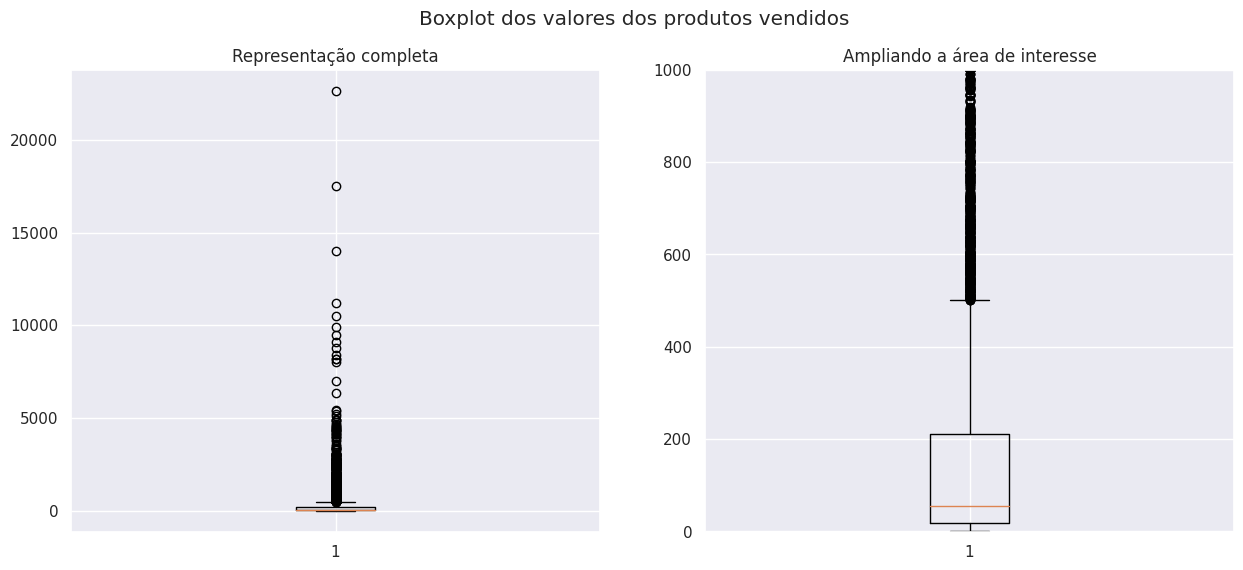

In [52]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))

fig.suptitle('Boxplot dos valores dos produtos vendidos')

ax1.boxplot(df['Sales'])
ax1.set(title='Representação completa')

ax2.boxplot(df['Sales'])
ax2.set(title='Ampliando a área de interesse')

ax2.axis([0.5, 1.5, -1, 1000])
plt.show()

De fato, é possível notar que diversos valores foram considerados outliers. É importante ressaltar que esse comportamento pode influenciar negativamente a capacidade de aprendizado do nosso modelo. Porém, o problema proposto não é o de prever futuras compras de produtos individuais. O modelo proposto irá prever linhas do dataframe que será mostrado a seguir, que contém o valor agregado de compras a cada dia.

Agora que conhecemos os comportamentos individuais de todas as variáveis, podemos passar para as análises que combinem os diferentes atributos, onde obteremos gráficos e insights mais interessantes.

---
## 3.2 - Análise das vendas por datas

Geralmente esta etapa começaria com a confecção de gráficos de dispersão e estudo da matriz de correlação do dataframe. Porém, além de várias de nossas variáveis serem categóricas nominais (impossibilitando retirar a informação de correlação), o foco deste MVP é a análise e previsão das vendas em cada dia. Logo, começaremos criando e estudando um novo dataframe, feito a partir dos dados do dataframe original `df`. Este dataframe inicialmente consistirá nos valores de compras agrupados por dia. 

---
### Vendas por dia

O primeiro passo é selecionar as variáveis que achamos que serão relevantes para o aprendizado de máquina e nossa análise da variação das compras por dia. Obviamente, a data e a soma do valor das compras precisam estar presente. A quantidade de produtos comprados em cada dia também será interessante de se observar. Para finalizar, será interessante ter acesso às informações referentes à data, isto é, o dia da semana e se é feriado no dia que o pedido foi efetivado.

Além de adicionar as variáveis citadas, a célula abaixo também adicionará os dias faltantes, já que o *groupby* acabaria ignorando os dias que não tiveram vendas.

In [53]:
# Montando o novo dataframe

# Agrupa a contagem de produtos vendidos e a soma dos valores por data
df_date_count = df.groupby('Order Date')['Sales'].count()
df_date_sum = df.groupby('Order Date')['Sales'].sum()

# Cria um dataframe com os agrupamentos
df_by_date = pd.DataFrame({'número de vendas':df_date_count.T,
                         'soma das vendas':df_date_sum.T})

# Adiciona os dias faltantes que não tiveram vendas
df_by_date = df_by_date.asfreq('D', fill_value=0)

# Copia a data que ficou no índice para uma nova coluna
df_by_date['Date'] = df_by_date.index

# Recria a coluna de feriados e dia da semana
df_by_date['Is Holiday'] = df_by_date['Date'].isin(us_holidays)
df_by_date['Weekday'] = df_by_date['Date'].dt.day_name()

# Reorganiza as colunas do dataframe novo
mover_coluna(df_by_date, 'Is Holiday', 0)
mover_coluna(df_by_date, 'Weekday', 0)
mover_coluna(df_by_date, 'Date', 0)

df_by_date

,Date,Weekday,Is Holiday,número de vendas,soma das vendas
Order Date,,,,,
2015-01-03,2015-01-03,Saturday,False,1,16.4480
2015-01-04,2015-01-04,Sunday,False,3,288.0600
2015-01-05,2015-01-05,Monday,False,1,19.5360
2015-01-06,2015-01-06,Tuesday,False,9,4407.1000
2015-01-07,2015-01-07,Wednesday,False,2,87.1580
...,...,...,...,...,...
2018-12-26,2018-12-26,Wednesday,False,4,814.5940
2018-12-27,2018-12-27,Thursday,False,2,177.6360
2018-12-28,2018-12-28,Friday,False,19,1657.3508


Com o dataframe formado, podemos começar estudar esse novo dataframe, focando na nossa variável objetivo. Começaremos com os gráficos de dispersão relativos à soma das vendas.

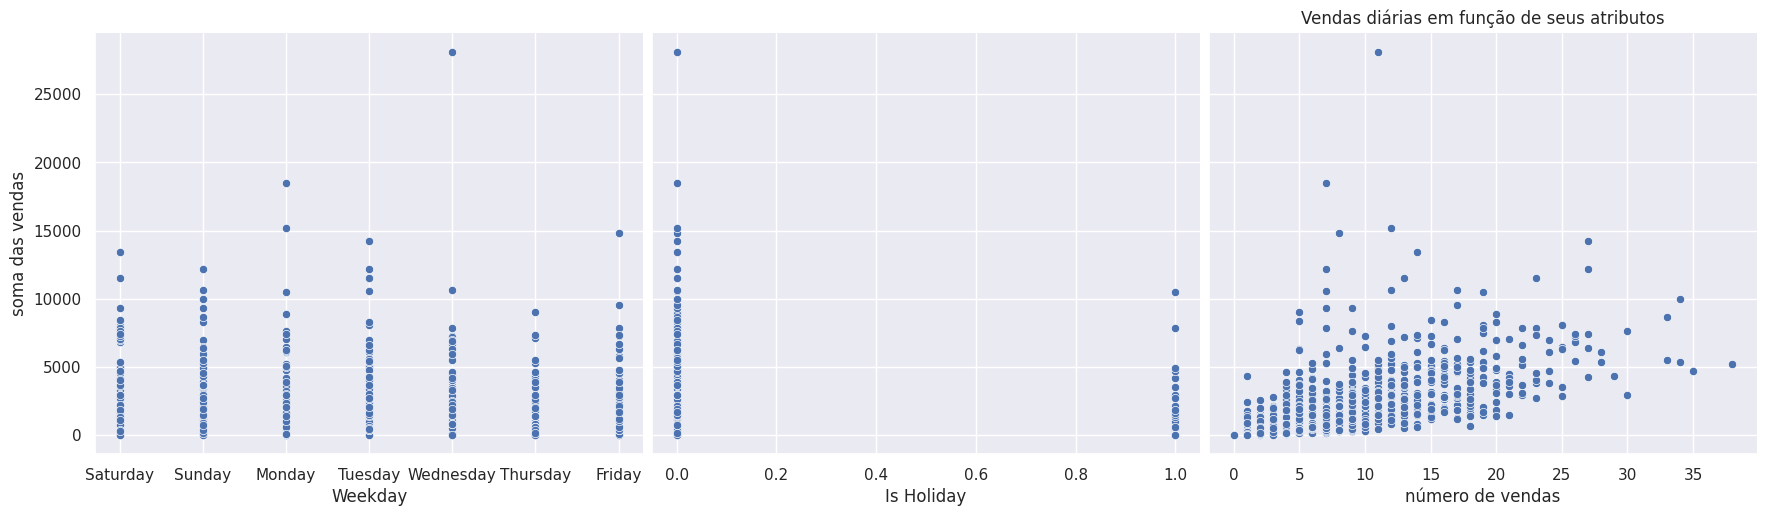

In [54]:
sns.pairplot(data=df_by_date, x_vars=['Weekday', 'Is Holiday', 'número de vendas'],
             y_vars=['soma das vendas'], height=5, aspect=1.2)

plt.title('Vendas diárias em função de seus atributos')
plt.show()

A única tendência que se nota referente aos dias da semana é uma pequena queda na quinta-feira. Nos feriados, ao contrário do que se esperava, nota-se uma tendência de ter valores menores de vendas diárias. Por fim, como esperado, existe uma tendência do valor diário das vendas aumentar com o número de vendas efetivadas naquele dia.

Notam-se alguns valores consideravelmente maiores que a média. Para explorar esses valores plota-se o boxplot da soma diária.

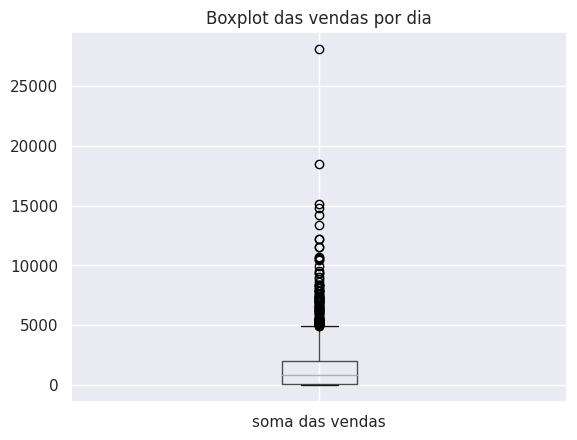

In [55]:
df_by_date.boxplot('soma das vendas')
plt.title('Boxplot das vendas por dia')
plt.show()

Vemos que, além de ter vários valores considerados como outliers no boxplot, um em especial é bem maior que os outros. A fim de descobrir mais sobre o dia com mais vendas, procuramos mais informações sobre ele no dataset de produtos.

In [56]:
dia_com_mais_vendas = df_by_date['soma das vendas'].idxmax()
df[df['Order Date'] == dia_com_mais_vendas]

,Order ID,Order Date,Order Weekday,Is Holiday,Ship Date,Ship Delay,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,,
2697,CA-2015-145317,2015-03-18,Wednesday,False,2015-03-23,5,Standard Class,SM-20320,Home Office,"Jacksonville, Florida",Florida,32216,South,TEC-MA-10003626,Technology,Machines,Hewlett-Packard Deskjet 6540 Color Inkjet Printer,821.300
2698,CA-2015-145317,2015-03-18,Wednesday,False,2015-03-23,5,Standard Class,SM-20320,Home Office,"Jacksonville, Florida",Florida,32216,South,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480
2699,CA-2015-145317,2015-03-18,Wednesday,False,2015-03-23,5,Standard Class,SM-20320,Home Office,"Jacksonville, Florida",Florida,32216,South,OFF-PA-10001804,Office Supplies,Paper,Xerox 195,21.376
2700,CA-2015-145317,2015-03-18,Wednesday,False,2015-03-23,5,Standard Class,SM-20320,Home Office,"Jacksonville, Florida",Florida,32216,South,OFF-AR-10003183,Office Supplies,Art,Avery Fluorescent Highlighter Four-Color Set,8.016
2701,CA-2015-145317,2015-03-18,Wednesday,False,2015-03-23,5,Standard Class,SM-20320,Home Office,"Jacksonville, Florida",Florida,32216,South,FUR-FU-10004270,Furniture,Furnishings,"Executive Impressions 13"" Clairmont Wall Clock",30.768
2702,CA-2015-145317,2015-03-18,Wednesday,False,2015-03-23,5,Standard Class,SM-20320,Home Office,"Jacksonville, Florida",Florida,32216,South,OFF-FA-10003112,Office Supplies,Fasteners,Staples,18.936
2703,CA-2015-145317,2015-03-18,Wednesday,False,2015-03-23,5,Standard Class,SM-20320,Home Office,"Jacksonville, Florida",Florida,32216,South,FUR-FU-10001986,Furniture,Furnishings,"Dana Fluorescent Magnifying Lamp, White, 36""",122.352
6152,CA-2015-111871,2015-03-18,Wednesday,False,2015-03-21,3,Second Class,EK-13795,Home Office,"San Francisco, California",California,94110,West,FUR-BO-10004218,Furniture,Bookcases,Bush Heritage Pine Collection 5-Shelf Bookcase...,1198.330
7328,US-2015-131275,2015-03-18,Wednesday,False,2015-03-24,6,Standard Class,SC-20050,Home Office,"Burbank, California",California,91505,West,FUR-FU-10004597,Furniture,Furnishings,Eldon Cleatmat Chair Mats for Medium Pile Carpets,111.000


Nota-se que o outlier em `df_by_date` é causado pelo produto mais caro em `df` (segunda linha do dataframe acima), já visto na seção anterior. Será considerado tratar esse e os outros outliers na próxima seção.

Para estudar a distribuição e variação ao longo do tempo, plota-se os valores diários das vendas.

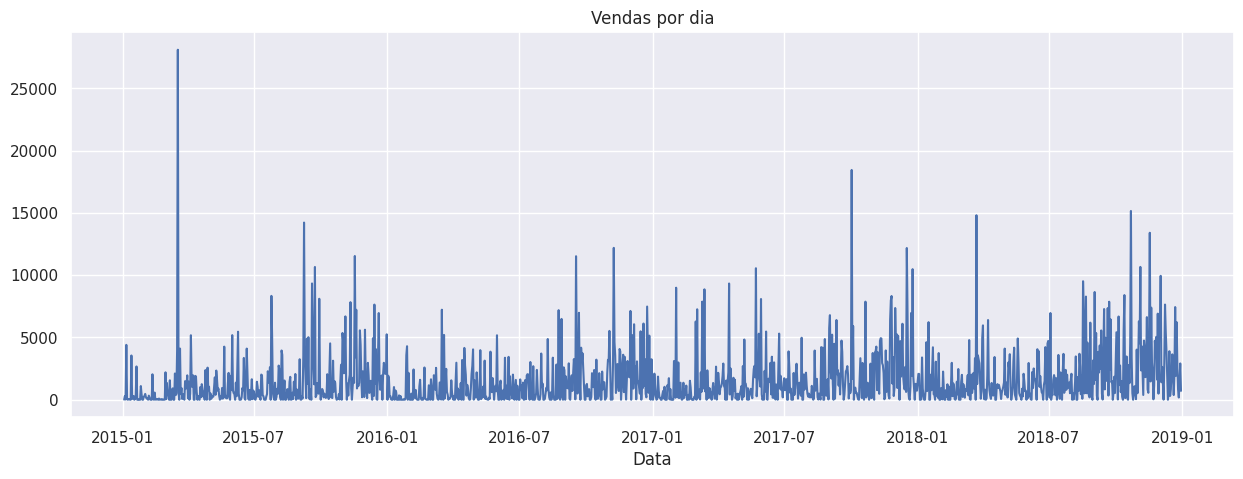

In [57]:
plt.figure(figsize=[15,5])

plt.plot(df_by_date['soma das vendas'])

plt.title('Vendas por dia')
plt.xlabel('Data')

plt.show()

Nota-se no gráfico acima que existem diversos picos de vendas, indicando grande variação de dia a dia. Como temos um número muito grande de pontos, fica difícil visualizar o comportamento no gráfico. A fim descobrir se existe um padrão para essa variação, serão feitos 4 gráficos, um para cada ano.

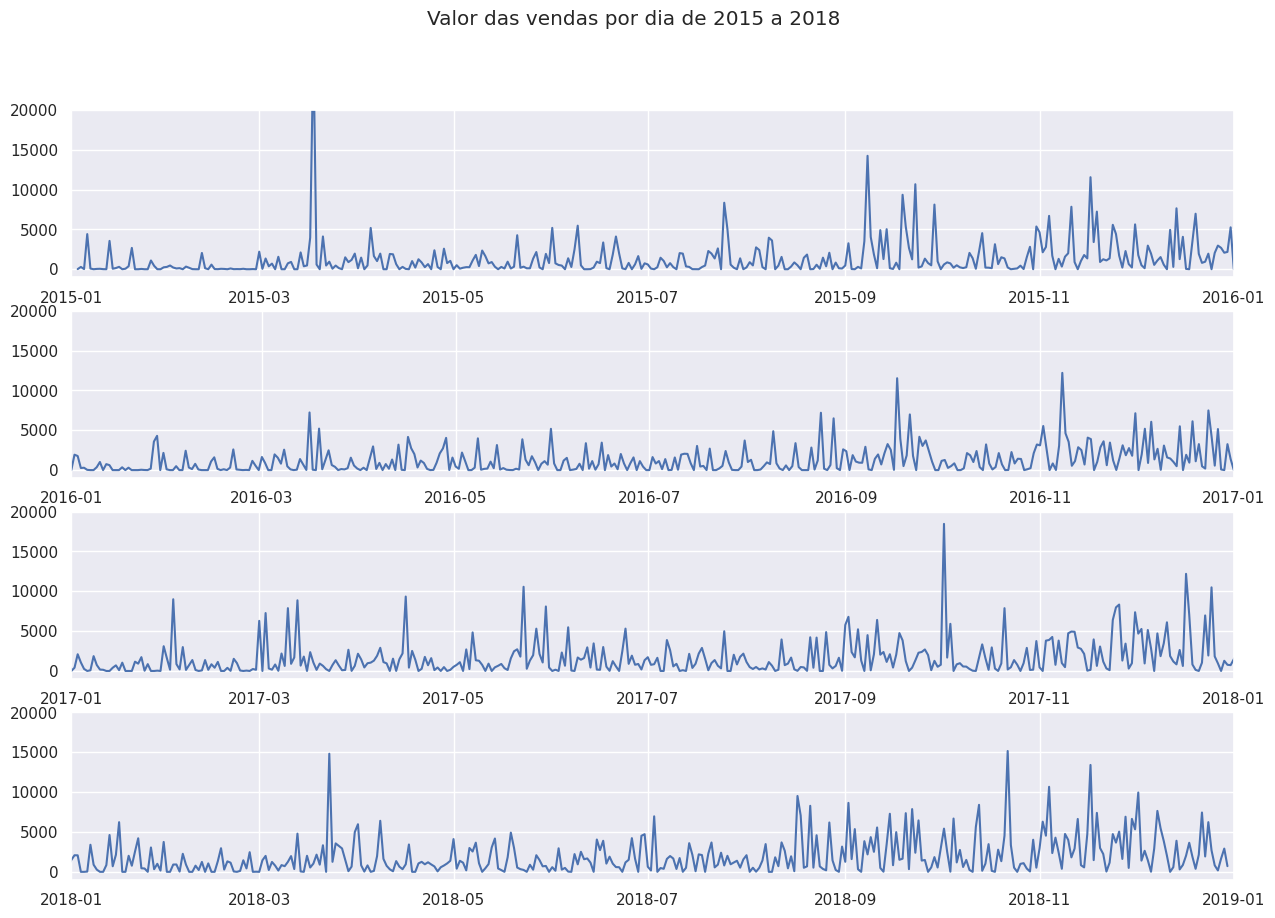

In [58]:
# Cria as datas limite de cada gráfico
data1 = datetime.date(2015,1,1)
data2 = datetime.date(2016,1,1)
data3 = datetime.date(2017,1,1)
data4 = datetime.date(2018,1,1)
data5 = datetime.date(2019,1,1)

# Limita o domínio do gráfico para manter as dimensões iguais nos 4
ymin = -1000
ymax = 20000

fig2,(ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(15,10))

fig2.suptitle('Valor das vendas por dia de 2015 a 2018')

ax1.plot(df_by_date['soma das vendas'])
ax1.axis([data1, data2, ymin, ymax])

ax2.plot(df_by_date['soma das vendas'])
ax2.axis([data2, data3, ymin, ymax])

ax3.plot(df_by_date['soma das vendas'])
ax3.axis([data3, data4, ymin, ymax])

ax4.plot(df_by_date['soma das vendas'])
ax4.axis([data4, data5, ymin, ymax])

plt.show()

Agora que conseguimos ver melhor cada pico e vale, podemos observar melhor as variações no valor de cada dia. É possível começar a notar alguns comportamentos, como o aumento de vendas no final de cada ano e a diminuição no início. 

Como ainda não está claro um padrão ao longo de cada mês, é escolhido um mês específico para ser estudado.

---
### Vendas diárias de novembro de 2018

A fim de verificar como nossos outros atributos influenciam as vendas, serão adicionados os feriados, segundas-feiras e o número de produtos vendidos em cada dia. Foi escolhido de novembro de 2018 porque ele possui um número razoável de feriados e picos.

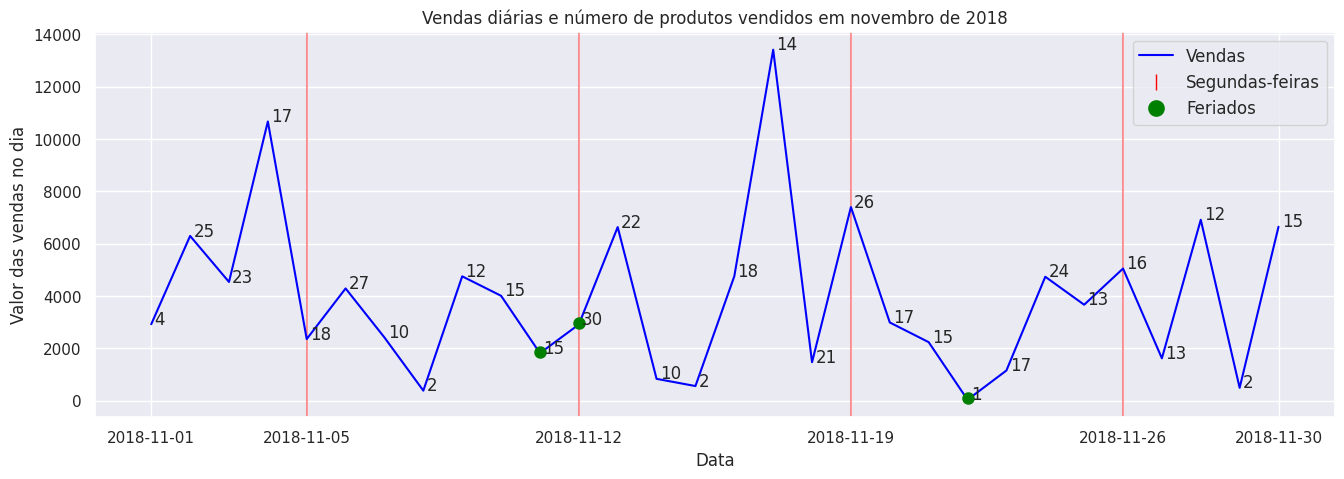

In [59]:
plt.figure(figsize=[16,5])

# Datas iniciais e finais do gráfico
data1 = datetime.datetime(2018, 11, 1)
data2 = datetime.datetime(2018, 12, 1)

# Filtro do dataframe pelas datas
df_mes = df_by_date[(df_by_date['Date'] >= data1) & (df_by_date['Date'] < data2)]

# Traça uma linha vertical vermelha nas segundas-feiras
df_mondays = df_mes[df_mes['Weekday'] == 'Monday']['Date']
for monday in df_mondays:
  plt.axvline(monday, color='red', alpha=0.4)

# Plota o gráfico das vendas
plt.plot(df_mes['soma das vendas'], color='blue')

# Traça um círculo verde nos dias de feriados
df_holidays = df_mes[df_mes['Is Holiday'] == True][['Date', 'soma das vendas']]
for feriado, venda in zip(df_holidays['Date'], df_holidays['soma das vendas']):
  plt.plot(feriado, venda+50, 'o', ms=7, mec='green', mfc='green', mew=2)

# Anota o número de vendas em cada dia
delta = datetime.timedelta(hours=2)
for vendas, data, n in zip(df_mes['soma das vendas'], df_mes['Date'], 
                           df_mes['número de vendas']):
    plt.annotate(n, xy = (data + delta, vendas))

# Cria elementos personalisados da legenda
custom_legends = [Line2D([0], [0], color='blue', label='Vendas'),
                  Line2D([0], [0], color='red', marker='|', lw=0, label='Segundas-feiras'),
                  Line2D([0], [0], color='blue', marker='o', ms=5, mec='green',
                         mfc='green', mew=2, lw=0, label='Feriados')]

# Ajustes do gráfico
plt.title('Vendas diárias e número de produtos vendidos em novembro de 2018')
plt.xlabel('Data')
plt.ylabel('Valor das vendas no dia')
plt.xticks([datetime.date(2018, 11, 1), datetime.date(2018, 11, 5),
            datetime.date(2018, 11, 12), datetime.date(2018, 11, 19),
            datetime.date(2018, 11, 26), datetime.date(2018, 11, 30)])
plt.legend(handles=custom_legends, markerscale=2, fontsize=12)
plt.savefig('vendas_nov_2018.png', format='png')
plt.show()

Mesmo adicionando as outras variáveis disponíveis, ainda é difícil observar um padrão claro no valor das vendas diárias.

A informação de número dos produtos vendidos (indicada pelo número em cada ponto) não é suficiente para causar picos, como pode ser notado ao se comparar os primeiros cinco pontos do gráfico acima. Olhando especificamente para o quarto e quinto ponto, mesmo com um número próximo de produtos vendidos (17 e 18), um valor corresponde a quase 500% do outro. Isso se deve ao grande delta de valores possíveis para os produtos, vistos na análise individual de `Sales` e repetido na célula abaixo.

In [60]:
print('Produto de menor valor: ' + str(min(df['Sales'])))
print('Produto de maior valor: ' + str(max(df['Sales'])))

Produto de menor valor: 0.444
Produto de maior valor: 22638.48


Ainda em relação ao gráfico acima, não foi possível verificar picos de vendas esperados nos feriados. Na verdade, nota-se até que os dias de feriados parecem tender a ser mínimos locais, o que já foi observado no gráfico de dispersão no início de **3.2**. Para visualizar essa diferença, plota-se as médias de feriados e dias normais em todos os anos.

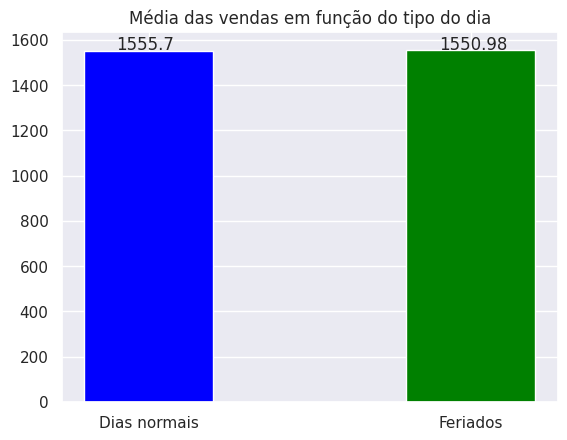

In [61]:
media_feriados = df_by_date[df_by_date['Is Holiday'] == True]['soma das vendas'].mean()
media_naoferiados = df_by_date[df_by_date['Is Holiday'] == False]['soma das vendas'].mean()

plt.title('Média das vendas em função do tipo do dia')
plt.bar(['Dias normais', 'Feriados'], [media_naoferiados, media_feriados],
        color=['blue', 'green'], width=0.4)

plt.annotate(media_feriados.round(2), xy=[-0.1, media_feriados])
plt.annotate(media_naoferiados.round(2), xy=[0.9, media_feriados])
plt.show()

Nota-se que os valores são incrivelmente próximos. Se voltarmos às análises individuais de categoria e de tipo de cliente, podemos inferir o porquê de as vendas não serem muito afetadas pelos feriados. Se tivéssemos majoritariamente compras de presentes, provavelmente teríamos picos nos feriados, mas como a loja também vende materiais de escritório e outros itens para trabalho, esse comportamento não ocorre.

No gráfico abaixo podemos ver qual o percentual das compras é realizado pelo tipo de consumidor e qual percentual é devido a cada tipo de produto.

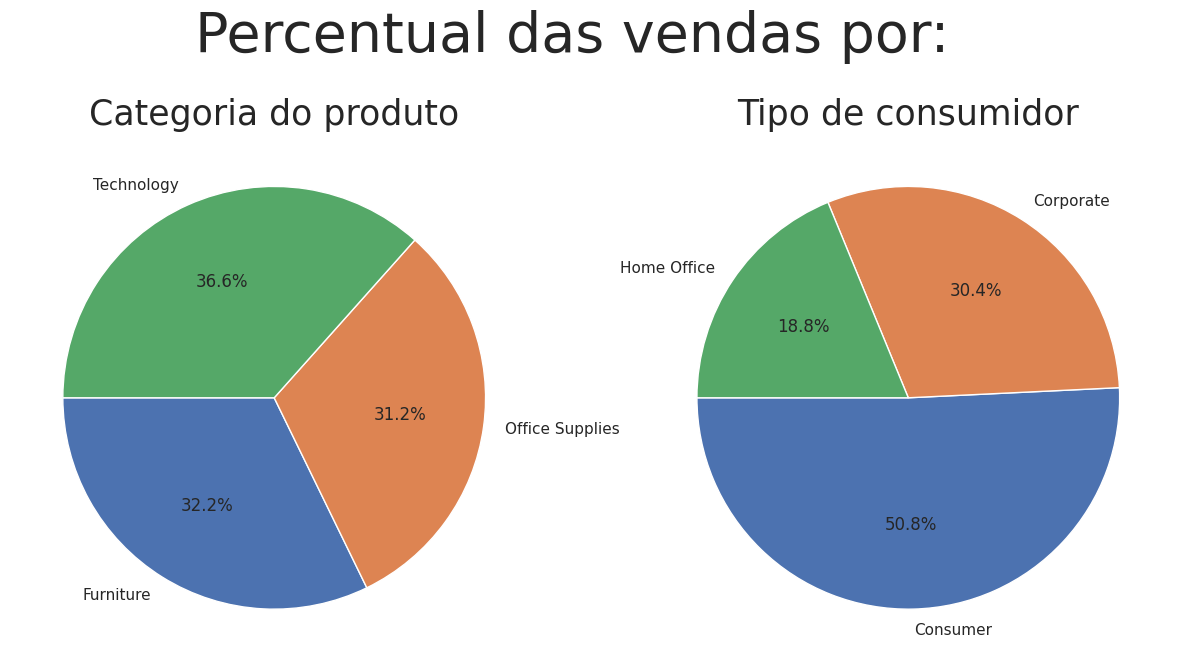

In [62]:
fig2,(ax1,ax2) = plt.subplots(1,2,figsize=(15,8))

fig2.suptitle('Percentual das vendas por:', size=40)

ax1.pie(df.groupby('Category')['Sales'].sum(),
        labels=df.groupby('Category')['Sales'].sum().index,
        autopct='%.1f%%',startangle=180)

ax1.set_title('Categoria do produto', size=25)

ax2.pie(df.groupby('Segment')['Sales'].sum(),
        labels=df.groupby('Segment')['Sales'].sum().index,
        autopct='%.1f%%', startangle=180)

ax2.set_title('Tipo de consumidor', size=25)

plt.show()

Vemos no gráfico acima que metade das vendas são pessoas fazendo compras para o trabalho e um terço são produtos de material de escritório, por isso não é possível notar o aumento de vendas em feriados.

Voltando para o gráfico de vendas diárias de novembro de 2018, a última informação adicionada ao gráfico que faltou comentar foi a de dias da semana. Observando os ciclos semanais entre as segundas-feiras, não é fácil observar um padrão simples. A fim de observar se existe um aumento ou diminuição nos diferentes dias da semana, plota-se um gráfico do somatório de cada dia.

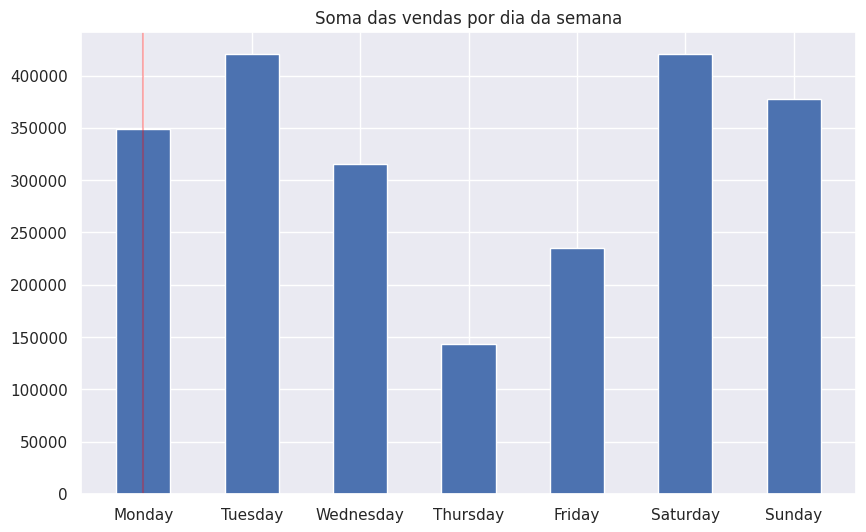

In [63]:
plt.figure(figsize=[10,6])

plt.title('Soma das vendas por dia da semana')

df_weekday = df_by_date.groupby('Weekday')['soma das vendas'].sum()
df_weekday = df_weekday.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                 'Friday', 'Saturday', 'Sunday'])

plt.bar(df_weekday.index, df_weekday, width=0.5)
plt.axvline(0, color='red', alpha=0.3)
plt.show()

Agora com as vendas agrupadas por dia, é mais fácil ver um padrão de oscilação. 

De fato, se voltarmos a observer o gráfico de vendas diárias de novembro de 2018 (repetido abaixo por conveniência), podemos notar que existe uma tendência de o mínimo da semana ser 3 dias depois das segundas-feiras, assim como uma tendência de existirem máximos locais nos dias próximos às segundas (entre sábado e terça).

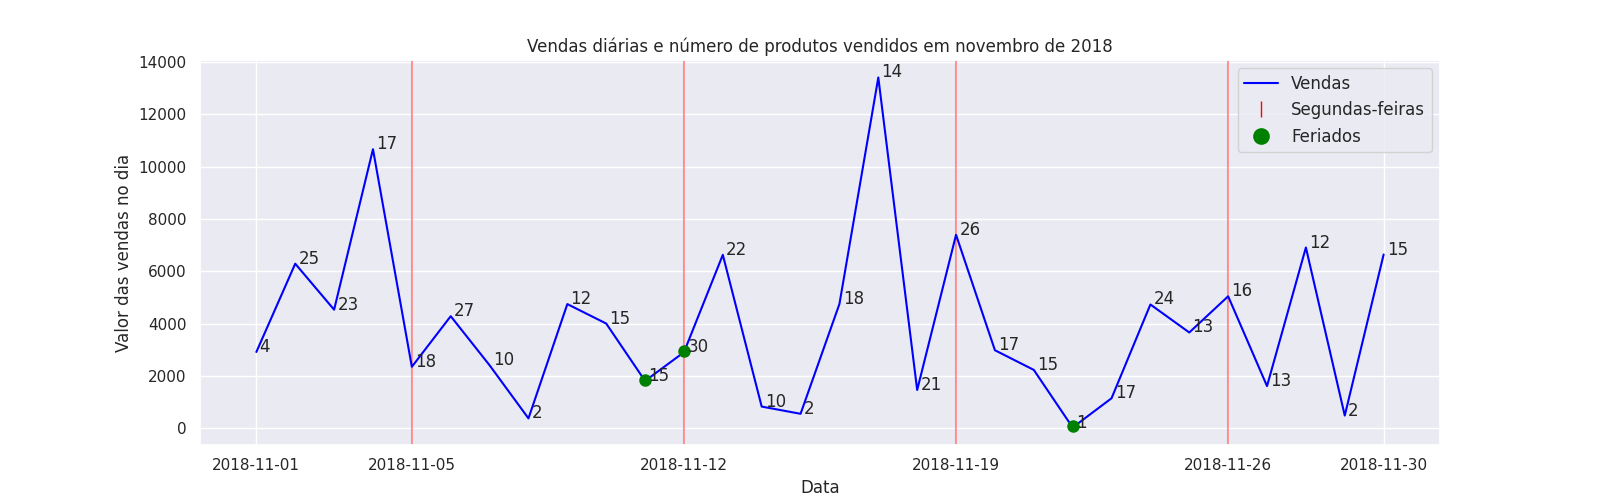

In [64]:
Image('vendas_nov_2018.png')

Mesmo que tenhamos conseguido identificar padrões, fica claro que a existe uma certa aleatoriedade nos valores das vendas por dia. Se a empresa tivesse um maior número de vendas por dia, a aleatoriedade do valor de vendas diárias acabaria sendo amenizada e ficaria mais fácil de ver as tendências. Porém, também é possível diminuir essa variância ao agregar dias em grupos, em vez de agrupar as vendas dia a dia. Apesar de esse agrupamento reduzir o 'ruído', ele acaba por causar um aumento na granularidade e perda de informação.

---
### Vendas por semana

Será interessante verificar como ficaria o comportamento das vendas se, em vez de somar por dia, as vendas fossem agrupadas por semana ou por mês. Já que existe muita variação nos valores diários das vendas, fica difícil perceber se existe uma sazonalidade dos valores. Em todo caso, se existir uma oscilação mais regular ao analisar os valores nos meses ou nas semanas, é provável que o modelo consiga mais precisão na previsão. Mesmo que esta não seja a proposta inicial do modelo, é benéfico apresentar uma alternativa.

In [65]:
# Adicionando as colunas de semana, mês e ano ao nosso dataframe
df_by_date2 = df_by_date.copy()

df_by_date2['Week'] = df_by_date2['Date']
df_by_date2['Week'] = df_by_date2['Week']-df_by_date2['Date'][0]
df_by_date2['Week'] = df_by_date2['Week'].dt.days
df_by_date2['Week'] = df_by_date2['Week'] / 7 + 1
df_by_date2['Week'] = df_by_date2['Week'].astype(int)
df_by_date2['Month'] = df_by_date2['Date'].dt.month
df_by_date2['Year'] = df_by_date2['Date'].dt.year

print('Amostra aleatória do dataset:')
df_by_date2.sample(4)

Amostra aleatória do dataset:


,Date,Weekday,Is Holiday,número de vendas,soma das vendas,Week,Month,Year
Order Date,,,,,,,,
2016-07-24,2016-07-24,Sunday,False,4,525.950,82,7,2016
2018-07-04,2018-07-04,Wednesday,True,0,0.000,183,7,2018
2017-01-27,2017-01-27,Friday,False,0,0.000,108,1,2017
2017-02-06,2017-02-06,Monday,False,1,132.224,110,2,2017


Com o novo dataframe de vendas por semana, é plotado o gráfico ao longo dos 4 anos:

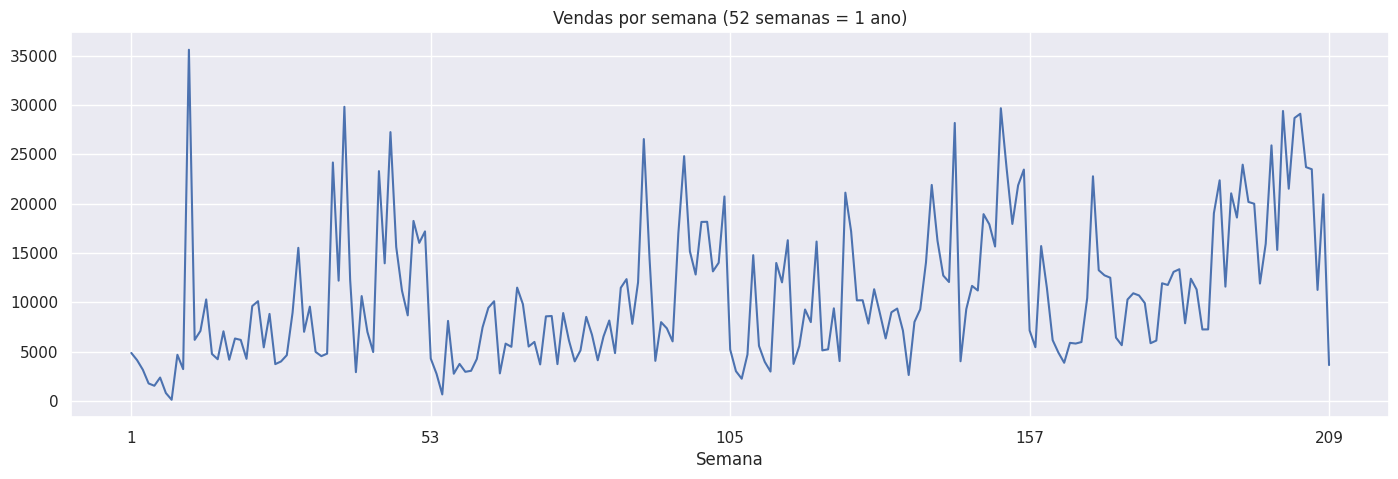

In [66]:
# Agrupa as vendas por número da semana
sales_by_week = df_by_date2.groupby('Week')['soma das vendas'].sum()

fig,ax = plt.subplots(1, 1, figsize=(17,5))

ax.plot(sales_by_week)

ax.set_title('Vendas por semana (52 semanas = 1 ano)')
ax.set_xlabel('Semana')
ax.set_xticks([1, 53, 105, 157, 209])

plt.show()

Com as vendas agrupadas e a variação diluída nos 7 dias da semana, começa-se a enxergar outros padrões. Nota-se um pouco de sazonalidade das vendas ao se observar o final dos anos, onde as vendas sempre apresentam valores maiores. Também é possível ver a leve tendência de aumento das vendas ao longo do ano.

Porém, a constante variação entre picos e vales ainda atrapalha visualmente. Tentando diminuir esse problema, plota-se o gráfico em escala logarítmica:

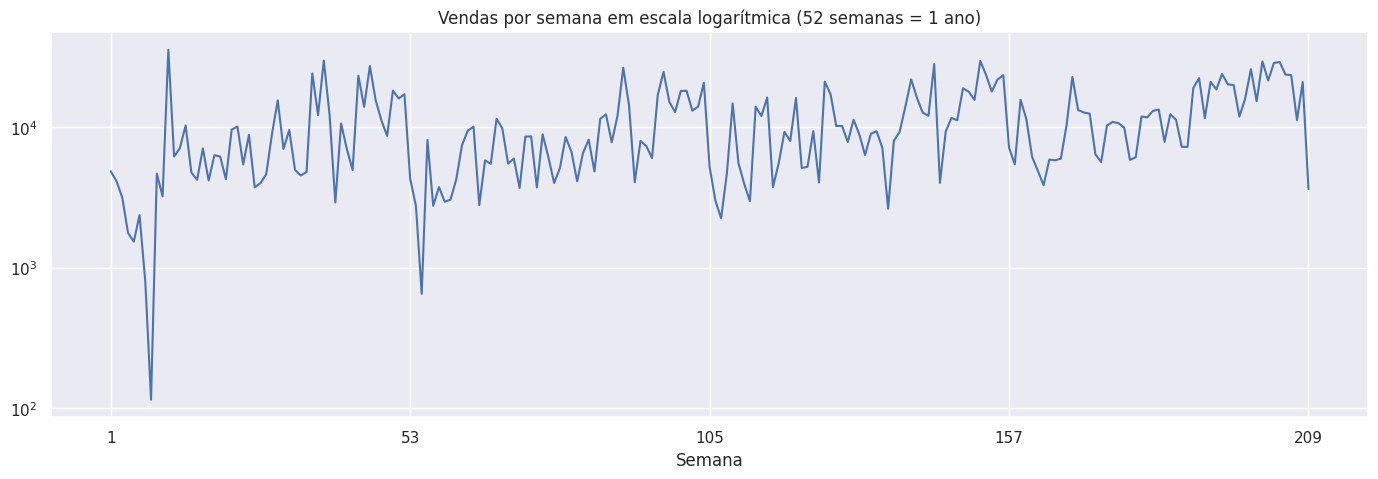

In [67]:
fig,ax = plt.subplots(1, 1, figsize=(17,5))

ax.plot(sales_by_week)

ax.set_title('Vendas por semana em escala logarítmica (52 semanas = 1 ano)')
ax.set_xlabel('Semana')
ax.set_xticks([1, 53, 105, 157, 209])
ax.set_yscale('log')

plt.show()

A escala logarítmica acaba ajudando a ter uma noção melhor dos valores dos mínimos locais, mas não foi possível notar nenhum comportamento diferente.

---
### Vendas por mês

Ainda na mesma lógica de diminuir o número de pontos para amenizar as variações, plota-se a soma das vendas por mês:

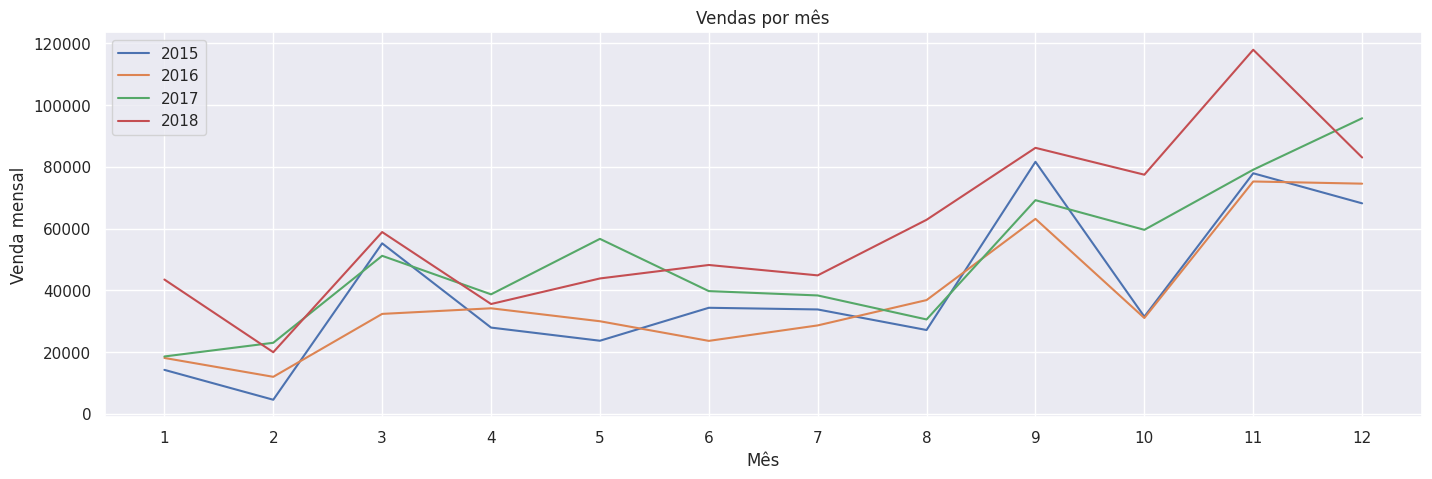

In [68]:
# Agrupa as vendas por mês
sales_by_month = df_by_date2.groupby(['Year','Month'])['soma das vendas'].sum()
sales_by_month = sales_by_month.reset_index(level=[0,1])

fig,ax = plt.subplots(1, 1, figsize=(17,5))

# Cria um dataset para cada ano
sales_m2015 = sales_by_month[sales_by_month['Year']==2015]['soma das vendas'].reset_index(drop=True)
sales_m2016 = sales_by_month[sales_by_month['Year']==2016]['soma das vendas'].reset_index(drop=True)
sales_m2017 = sales_by_month[sales_by_month['Year']==2017]['soma das vendas'].reset_index(drop=True)
sales_m2018 = sales_by_month[sales_by_month['Year']==2018]['soma das vendas'].reset_index(drop=True)

ax.plot(sales_m2015, label='2015')
ax.plot(sales_m2016, label='2016')
ax.plot(sales_m2017, label='2017')
ax.plot(sales_m2018, label='2018')

ax.set_xlabel('Mês')
ax.set_ylabel('Venda mensal')
ax.set_title('Vendas por mês')
ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
              labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

plt.legend()
plt.show()

No gráfico acima fica clara a sazonalidade das vendas. Com excessão do intervalo entre maio e julho, os anos apresentam quase as mesmas tendências, com mínimos e máximos locais em pelo menos 3 dos 4 anos. Por exemplo, o pico em novembro se apresenta em todos os anos, com excessão de 2017.

Também é possível observar a tendência de crescimento ao longo dos anos. Apesar de 2015 e 2016 ficarem variando sua colocação ao longo dos meses, é fácil perceber o crescimento das vendas em 2017 e ainda mais na segunda metade de 2018.



Como a visualização do gráfico acima é dificultada pela alta frequência de cruzamento de linhas, é feito um gráfico de barras com os mesmos dados.

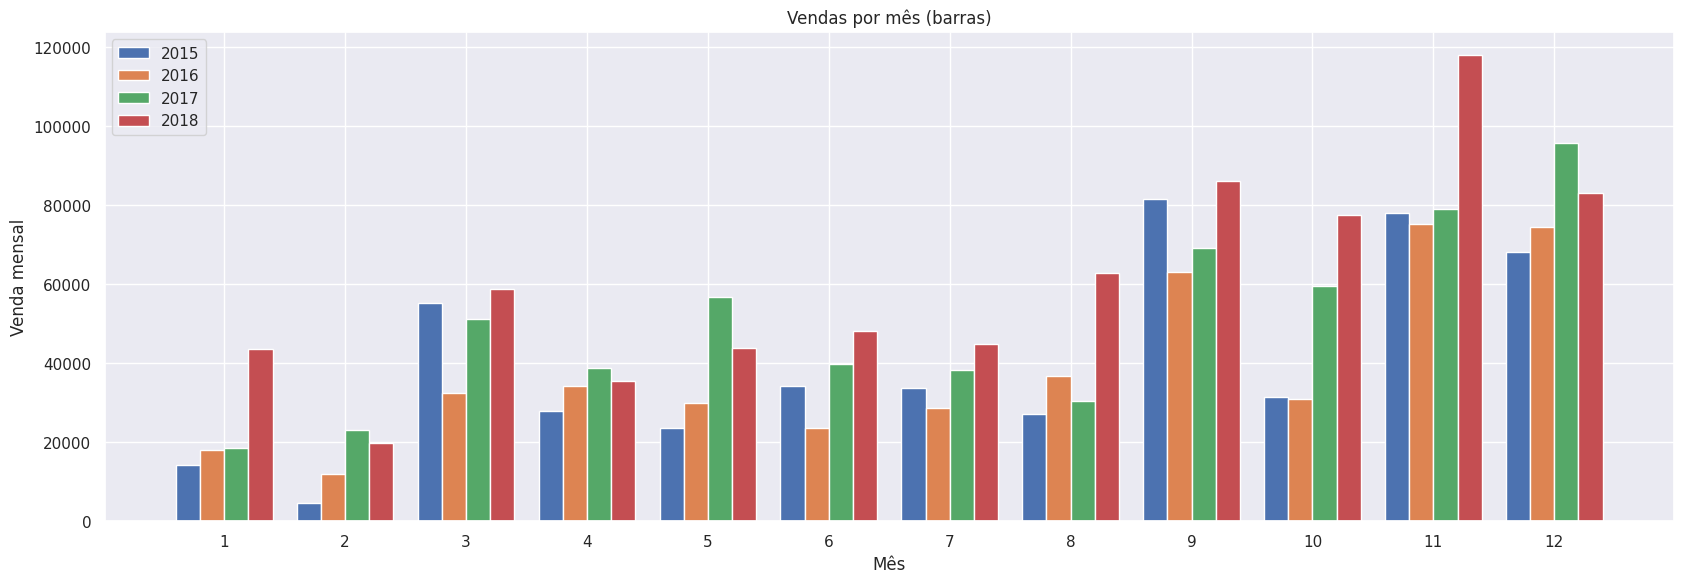

In [69]:
plt.figure(figsize=[17,6])

width = 0.2

plt.bar(x=np.arange(len(sales_m2015)), height=sales_m2015, width=width, label='2015')
plt.bar(x=np.arange(len(sales_m2016))+width, height=sales_m2016, width=width, label='2016')
plt.bar(x=np.arange(len(sales_m2017))+2*width, height=sales_m2017, width=width, label='2017')
plt.bar(x=np.arange(len(sales_m2018))+3*width, height=sales_m2018, width=width, label='2018')

plt.title('Vendas por mês (barras)')
plt.xlabel('Mês')
plt.ylabel('Venda mensal')
plt.xticks(np.arange(len(sales_m2015)) + 1.5*width,
           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

Agora separada em barras é mais fácil ver a mudança de posição relativa de vendas ao longo dos meses. Também é fácil perceber novamente que, com exceção do ano de 2018, a relação de aumento do volume de vendas com o passar dos anos não é tão clara.

---
### Vendas por ano

A fim de explorar mais o comportamento de cada ano, plota-se os valores da soma das vendas anuais.

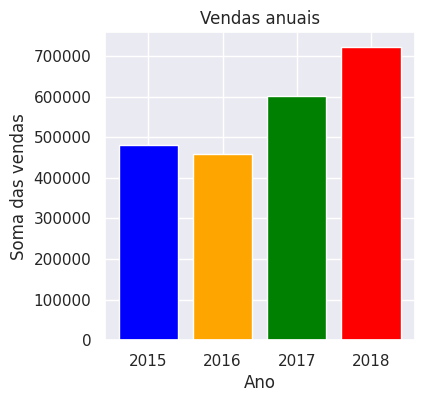

In [70]:
# Temos que resetar o pyplot porque estava dando erro no plt.xticks()
importlib.reload(plt)

plt.figure(figsize=[4,4])

sales_by_year = df_by_date2.groupby('Year').sum(numeric_only=True)

plt.bar(x=sales_by_year.index, height=sales_by_year['soma das vendas'],
        color=['blue', 'orange', 'green', 'red'])

plt.title('Vendas anuais')
plt.xlabel('Ano')
plt.ylabel('Soma das vendas')
plt.xticks([2015, 2016, 2017, 2018])
plt.show()

Nota-se que as vendas são quase as mesmas em 2015 e 2016, mas em 2017 e 2018 temos aumentos significativos.

---
### Correlações

Observadas as tendências citadas, exploraremos agora as correlações dos dataframes de vendas mensais e diárias.

Começando com o mensal:

In [71]:
sales_by_month.corr()['soma das vendas']

Year               0.326939
Month              0.727384
soma das vendas    1.000000
Name: soma das vendas, dtype: float64

Nota-se que a correlação com o ano é 0,33, que é uma correlação relevante, mas é relativamente baixa quando comparada à correlação do mês. Isso se deve ao comportamento observado no gráfico acima. Como a existe uma pequena queda de 2015 a 2016 e um aumento para os outros anos, a correlação linear entre os anos acabaria caindo.

Além disso, os valores não são dependentes apenas do ano. Se comparamos a venda de novembro de 2016 com a venda em janeiro de 2018 no gráfico 'Vendas por mês (barras)', o primeiro valor é consideravelmente maior, mesmo sendo de um ano anterior. Isso indica que o comportamento de sazonalidade é maior que a tendência de crescimento ao longo dos anos. De fato, essa sazonalidade fica bem clara no gráfico e no valor de correlação com o mês (0,73).

Antes de observar a correlação no dataframe das vendas diárias, é necessário mudar algumas colunas para valores numéricos.

In [72]:
df_by_date_numeric = df_by_date2.copy()
df_by_date_numeric['Weekday'] = df_by_date_numeric['Date'].dt.weekday
df_by_date_numeric['Day'] = df_by_date_numeric['Date'].dt.day
df_by_date_numeric.drop(columns='Date', inplace=True)
df_by_date_numeric.head()

,Weekday,Is Holiday,número de vendas,soma das vendas,Week,Month,Year,Day
Order Date,,,,,,,,
2015-01-03,5,False,1,16.448,1,1,2015,3
2015-01-04,6,False,3,288.060,1,1,2015,4
2015-01-05,0,False,1,19.536,1,1,2015,5
2015-01-06,1,False,9,4407.100,1,1,2015,6
2015-01-07,2,False,2,87.158,1,1,2015,7


Agora que todos os valores são numéricos, podemos calcular os valores de correlação do dataframe de vendas diárias.

In [73]:
df_by_date_numeric.corrwith(df_by_date_numeric['soma das vendas'], numeric_only=True)

Weekday            -0.000151
Is Holiday          0.000365
número de vendas    0.663043
soma das vendas     1.000000
Week                0.182328
Month               0.262975
Year                0.120042
Day                -0.013850
dtype: float64

Nota-se que as correlações com mês e ano caíram para aproximadamente um terço, comparado com os valores do dataframe agrupado por mês. Essa queda acontece porque, ao agrupar as vendas por mês, a variação de cada dia (observada no início desta subseção) acaba sendo diluída e uma variação positiva de um dia é compensada pela negativa de outro dia. Com essa variância reduzida as tendências ficam mais evidentes, seja a tendência de crescimento ao longo dos anos ou a tendência de sazonalidade indicada pelo mês.

Também vale comentar sobre o valor muito pequeno da correlação das vendas com o atributo de feriado. O valor de 0,00036 ressalta a irrelevância deste atributo, assim como foi visto no gráfico de 'Média das vendas em função do tipo do dia', onde o valor médio das vendas em dias de feriados e não feriados teve uma diferença de apenas 0,3%.

Por fim, é interessante ressaltar a relevância da correlação para o modelo de machine learning. Apesar de não implicar diretamente, um baixo valor de correlação com os atributos em questão pode indicar que o nosso modelo terá dificuldades em prever corretamente os valores de vendas diárias.

Por outro lado, ao agrupar os dias em semanas ou meses, perdemos as informações, por exemplo, de dias da semana e feriados. Mesmo que esses atributos tenham correlação baixa com o valor diário das vendas, é possível que eles contenham informação o suficiente para ajudar na acurácia do modelo.

Obviamente, estes não são os únicos fatores relevantes para a acurácia do modelo, mas seria interessante fazer um estudo que leva em conta o *trade-off* entre precisão do modelo e a importância de prever o valor diário em vez do valor mensal ou semanal.

---
## 3.3 - Demais análises

Na subseção 3.2 foram realizadas análises com foco no objetivo principal deste MVP. Nesta subseção, serão feitas análises que não são imediatamente relevantes para a preparação dos dados ou a futura construção do modelo de previsão de série temporal. Porém, como temos os dados originais de cada compra, existem algumas análises simples que podem ser relevantes para outras áreas da empresa. Por exemplo, ajudaria o time de *marketing* saber para quem e para quais produtos direcionar suas propagandas.

---
### Quem compra o que

Uma pergunta muito comum na área de vendas é saber qual tipo de comprador compra qual tipo de produto. Primeiramente temos que comparar o total de vendas de cada tipo de consumidor, a fim de saber se eles que tipo comprou mais. Para esta análise, serão agrupados os consumidores de trabalho remoto e corporativo em um único tipo: trabalho (`'Work'`). Além disso, como esta é uma pergunta que guiará ações no presente e futuro da empresa, será serão selecionadas vendas mais recentes (ano de 2018).

In [74]:
df2 = df.replace(['Home Office', 'Corporate'], 'Work')
df2 = df2[df2['Order Date'].dt.year == 2018]
df2.groupby('Segment')['Sales'].sum()

Segment
Consumer    328604.4719
Work        393447.5473
Name: Sales, dtype: float64

Note que os valores das compras para trabalho são maiores que consumidores individuais. Isso já é uma informação importante para o direcionamento do investimento em *marketing*.

Agora podemos responder à pergunta: que tipos de produtos são comprados para trabalho e para demais motivos:

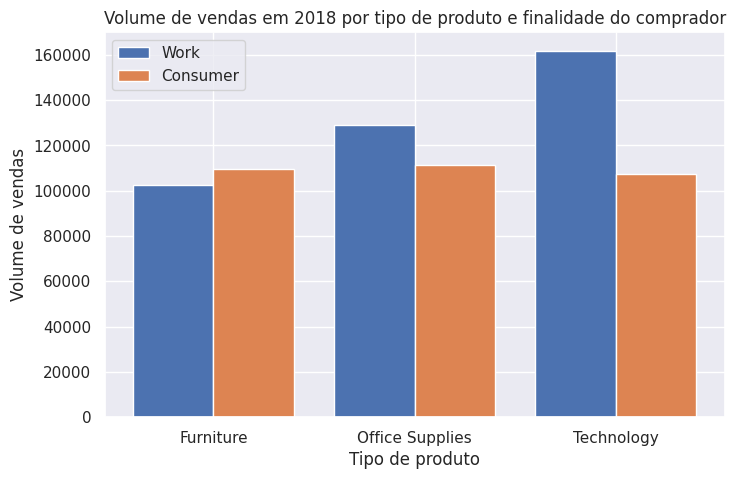

In [75]:
df_SC = df2.groupby(['Segment', 'Category'])['Sales'].sum()
df_SC = df_SC.reset_index(level=[0, 1])
df_SC_work = df_SC[df_SC['Segment'] == 'Work'].reset_index(drop=True)
df_SC_consumer = df_SC[df_SC['Segment'] == 'Consumer'].reset_index(drop=True)

plt.figure(figsize=[8,5])
width = 0.4

plt.bar(x=np.arange(len(df_SC_work)), 
        height=df_SC_work['Sales'], width=width, label='Work')
plt.bar(x=np.arange(len(df_SC_consumer)) + width, 
        height=df_SC_consumer['Sales'], width=width, label='Consumer')

plt.title('Volume de vendas em 2018 por tipo de produto e finalidade do comprador')
plt.xlabel('Tipo de produto')
plt.ylabel('Volume de vendas')
plt.xticks(np.arange(len(df_SC_consumer)) + width/2,
           labels=df_SC_work['Category'].unique())
plt.legend()
plt.show()

Note que mesmo que consumidores comuns tenham menor participação nas vendas de 2018, eles compraram mais mobília do que trabalhadores. Porém, a categoria que mais vendeu foi a de tecnologia, na qual as compras para trabalho lideram significativamente.

---
### Evolução dos tipos de produto

Surge a pergunta: a categoria de tecnologia sempre foi a mais importante para a empresa? É interessante para uma empresa saber a evolução de suas vendas ao longo dos anos, a fim de fazer projeções e tentar estar à frente das mudanças. Para isso, será feito um gráfico da evolução das vendas para cada categoria de produto.

In [76]:
df3 = df.copy()
df3['Year'] = df3['Order Date'].dt.year
df_YC = df3.groupby(['Year', 'Category'])['Sales'].sum()
df_YC = df_YC.reset_index(level=[0,1])
df_YC_fur = df_YC[df_YC['Category'] == 'Furniture'].reset_index(drop=True)
df_YC_os = df_YC[df_YC['Category'] == 'Office Supplies'].reset_index(drop=True)
df_YC_tec = df_YC[df_YC['Category'] == 'Technology'].reset_index(drop=True)

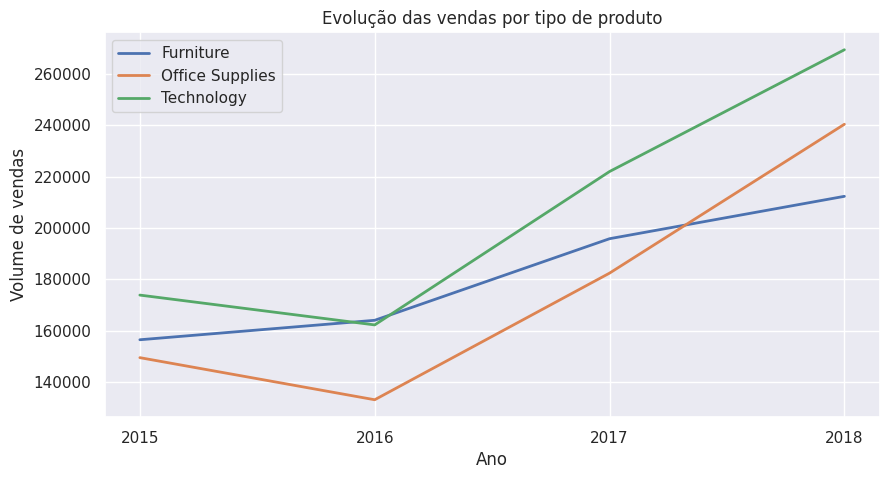

In [77]:
plt.figure(figsize=[10,5])

plt.plot(df_YC_fur['Year'], df_YC_fur['Sales'], label='Furniture', lw=2)
plt.plot(df_YC_os['Year'], df_YC_os['Sales'], label='Office Supplies', lw=2)
plt.plot(df_YC_tec['Year'], df_YC_tec['Sales'], label='Technology', lw=2)

plt.title('Evolução das vendas por tipo de produto')
plt.xlabel('Ano')
plt.ylabel('Volume de vendas')
plt.xticks(df_YC_fur['Year'])
plt.legend()
plt.show()

Note que as mobílias vendidas pela empresa representam um percentual cada vez menor do volume de vendas após 2016, quando chegou a ser a categoria mais vendida. Ao mesmo tempo, depois de 2016, os materiais de escritório e os itens de tecnologia entram em ascensão. Em uma análise inicial, é possível inferir que existe uma tendência das vendas de mobílias se tornarem um percentual cada vez menor do lucro da empresa.

---
### Onde se concentra cada tipo de venda

Uma pergunta muito importante para uma empresa desse tipo é saber onde estão concentradas as vendas de cada categoria. Sabendo em qual região as vendas dos tipos de produtos se concentram, o setor de logística consegue minimizar os custos de armazenamento e transporte. Assim como na primeira pergunta desta subseção, apenas a informação mais recente (2018) é relevante.

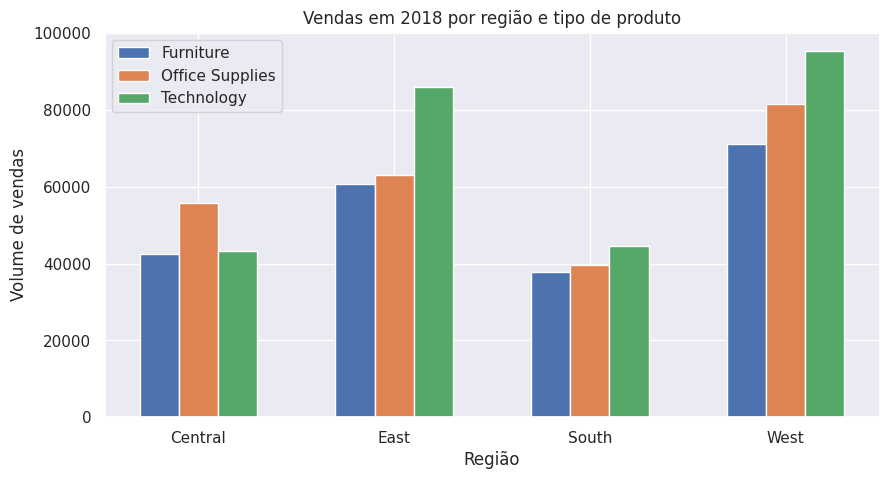

In [78]:
df4 = df.copy()
df4 = df4[df4['Order Date'].dt.year == 2018]
df_RC = df4.groupby(['Region','Category'])['Sales'].sum()
df_RC = df_RC.reset_index(level=[0,1])

df_RC_fur = df_RC[df_RC['Category'] == 'Furniture'].reset_index(drop=True)
df_RC_os = df_RC[df_RC['Category'] == 'Office Supplies'].reset_index(drop=True)
df_RC_tec = df_RC[df_RC['Category'] == 'Technology'].reset_index(drop=True)

width = 0.2
plt.figure(figsize=[10,5])

plt.bar(x=np.arange(len(df_RC_fur)), height=df_RC_fur['Sales'],
        width=width, label='Furniture')
plt.bar(x=np.arange(len(df_RC_os)) + width, height=df_RC_os['Sales'],
        width=width, label='Office Supplies')
plt.bar(x=np.arange(len(df_RC_tec)) + 2*width, height=df_RC_tec['Sales'],
        width=width, label='Technology')

plt.title('Vendas em 2018 por região e tipo de produto')
plt.xlabel('Região')
plt.ylabel('Volume de vendas')
plt.xticks(np.arange(len(df_RC_fur))+width, labels=df_RC_fur['Region'].unique())
plt.legend()
plt.show()

Nota-se que a região central é a única em que o volume de vendas de material de escritório é maior do que os outros. Nas outras regiões os produtos de tecnologia são líderes em vendas, sendo a diferença mais acentuada na região leste. Também é possível notar que a região sul tem uma distribuição equilibrada de produtos, apesar de ser a região com menor volume de vendas.

---
### Atraso de entregas de 'mesmo dia'

Em **3.1** foi observado que existem envios de tipo *Same Day* que não foram entregues no mesmo dia. A primeira suposição é que esses pedidos foram efetivados depois do horário comercial. Apesar de não termos a informação de horário do pedido, podemos observar as entregas que tiveram este problema para inferir outros motivos para o atraso.

In [79]:
df_atraso = df.copy()
df_atraso = df_atraso[(df_atraso['Ship Mode'] == 'Same Day') & 
                      (df_atraso['Ship Delay'] != 0)]
df_atraso

,Order ID,Order Date,Order Weekday,Is Holiday,Ship Date,Ship Delay,Ship Mode,Customer ID,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Row ID,,,,,,,,,,,,,,,,,,
1474,US-2016-105676,2016-12-01,Thursday,False,2016-12-02,1,Same Day,NM-18520,Consumer,"Houston, Texas",Texas,77036,Central,FUR-FU-10004270,Furniture,Furnishings,"Eldon Image Series Desk Accessories, Burgundy",6.688
2349,CA-2018-109701,2018-12-02,Sunday,False,2018-12-03,1,Same Day,AM-10360,Corporate,"Los Angeles, California",California,90032,West,OFF-BI-10004187,Office Supplies,Binders,3-ring staple pack,9.024
2350,CA-2018-109701,2018-12-02,Sunday,False,2018-12-03,1,Same Day,AM-10360,Corporate,"Los Angeles, California",California,90032,West,OFF-BI-10000632,Office Supplies,Binders,Satellite Sectional Post Binders,69.456
2351,CA-2018-109701,2018-12-02,Sunday,False,2018-12-03,1,Same Day,AM-10360,Corporate,"Los Angeles, California",California,90032,West,OFF-PA-10003724,Office Supplies,Paper,"Wirebound Message Book, 4 per Page",10.860
2352,CA-2018-109701,2018-12-02,Sunday,False,2018-12-03,1,Same Day,AM-10360,Corporate,"Los Angeles, California",California,90032,West,OFF-AP-10002765,Office Supplies,Appliances,Fellowes Advanced Computer Series Surge Protec...,79.470
2353,CA-2018-109701,2018-12-02,Sunday,False,2018-12-03,1,Same Day,AM-10360,Corporate,"Los Angeles, California",California,90032,West,OFF-AR-10001868,Office Supplies,Art,Prang Dustless Chalk Sticks,10.080
3042,CA-2018-149559,2018-09-11,Tuesday,False,2018-09-12,1,Same Day,KF-16285,Home Office,"Long Beach, California",California,90805,West,OFF-PA-10003172,Office Supplies,Paper,Xerox 1996,12.960
3043,CA-2018-149559,2018-09-11,Tuesday,False,2018-09-12,1,Same Day,KF-16285,Home Office,"Long Beach, California",California,90805,West,OFF-EN-10002312,Office Supplies,Envelopes,#10 Self-Seal White Envelopes,22.180
3044,CA-2018-149559,2018-09-11,Tuesday,False,2018-09-12,1,Same Day,KF-16285,Home Office,"Long Beach, California",California,90805,West,FUR-CH-10002320,Furniture,Chairs,Hon Pagoda Stacking Chairs,2054.272


Observando as instâncias acima é possível criar ou descartar as seguintes hipóteses sobre o atraso:

*   Não parece haver nenhuma predominância de dia da semana nos produtos atrasados. Logo, os atrasos não são causados pelo dia da semana.
*   Nenhum dos atrasos ocorreu em feriados. Logo, os feriados também não são a causa dos atrasos.
*   Os atrasos ocorreram principalmente em 2017 e 2018, o que significa que é um problema relativamente novo ou se agravou recentemente. Sobre esta afirmação, deve-se ter cuidado já que 2017 e 2018 foram os anos com maiores volumes de vendas, ou seja, eles têm naturalmente mais produtos e maior probabilidade de um atraso ser desta época. Logo, esta hipótese deve ser utilizada com mais cuidado.
*   A maioria dos atrasos se concentram na região oeste. Logo, os atrasos podem ser causados por um problema local.

Tendo em mente essas afirmações, seria recomendada uma investigação de possíveis fontes desse problema direcionadas à região oeste, focando em mudanças feitas em 2017 que se mantiveram em 2018.

Agora que obtivemos algumas informações a mais sobre o comportamento das vendas, podemos voltar para o foco do MVP.

---
# <center>4 - Pré-processamento
---


Nesta seção prepararemos o dataframe para ser utilizado no treinamento e validação do modelo de machine learning, tendo em mente os insights obtidos em **3.1** e **3.2**. 

Como o tipo do modelo não foi especificado ainda, será assumido que utilizaremos um modelo possívelmente sensível à grandes intervalos nos valores dos atributos e que aceita apenas variáveis numéricas.

---
## 4.1 - Resumo do que pode ser aproveitado

Primeiramente recapitularemos os processos que já foram feitos nas seções anteriores que também servirão para a etapa de pré-processamento:



1.   Foi fornecido da fonte um dataframe que possui cada produto vendido e sua data de efetivação. Como o objetivo do modelo será prever a soma das vendas de cada dia, o dataframe inicial foi transformado em um agrupamento por data.
2.   As datas foram convertidas e transformadas em 3 colunas diferentes. Inicialmente as datas vieram em formato de string, o que não pode ser processado pelo modelo. Não só isso, mesmo em formato de data, o modelo não conseguiria processar se não tivéssemos convertido em 3 atributos diferentes (ano, mês, dia) com tipo inteiro.
3.   Foram feitas novas variáveis para auxiliar a análise. Foram adicionamos os atributos de feriados e dia da semana. Esses atributos contêm informações sobre as datas e podem ajudar o modelo a identificar padrões.
4.   Os valores categóricos foram convertidos para numéricos. A coluna de dia da semana foi convertida de string para inteiro, onde o valor 0 representa uma segunda-feira e o valor 6 representa um dia de domingo.
5.   Foram criadas as linhas de datas faltantes, onde não houve nenhuma venda no dia.




Logo, será utilizado o dataframe numérico de vendas diárias. Porém, a coluna de número de vendas não será utilizada, já que o modelo não terá acesso e nem tem como objetivo inferir essa variável. Da mesma forma, a coluna de semana não é relevante para o dataframe de vendas diárias.

In [80]:
# Copia-se o dataframe para podermos manipular
df_ml = df_by_date_numeric.copy()
df_ml.drop(columns=['número de vendas', 'Week'], inplace=True)
df_ml.head()

,Weekday,Is Holiday,soma das vendas,Month,Year,Day
Order Date,,,,,,
2015-01-03,5,False,16.448,1,2015,3
2015-01-04,6,False,288.060,1,2015,4
2015-01-05,0,False,19.536,1,2015,5
2015-01-06,1,False,4407.100,1,2015,6
2015-01-07,2,False,87.158,1,2015,7


---
## 4.2 - Dia da semana

Iremos agora transformar o dia da semana em duas variáveis que melhor representem variáveis cíclicas. Geralmente, quando se trata de variáveis categóricas ordinais, o tratamento dado aos dias da semana até aqui é o suficiente. Porém, se prestarmos atenção no encoding utilizado, os dias de segunda-feira e terça-feira (0 e 1) parecem estar mais próximos do que os dias de domingo e segunda (6 e 0). Para resolver esse problema, serão utilizadas funções trigonométricas.

Se utilizarmos a função seno, por exemplo, conseguimos capturar a relação cíclica dos dias da semana, já que esta função oscila continuamente entre 0 e -1. Porém, se utilizarmos apenas essa função, temos o problema da duplicidade de valores para dois ângulos diferentes.


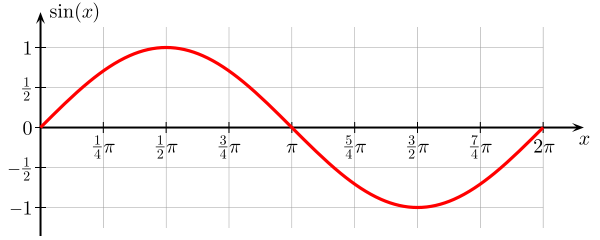

Na figura acima, podemos observar que π/4 e 3π/4 tem o mesmo valor de seno, logo, o modelo não conseguiria distinguir entre esses dois valores. Porém, como o cosseno apresenta o mesmo comportamento mas para valores diferentes, se passarmos os valores de seno e cosseno do dia da semana, podemos passar esse comportamento cíclico para o modelo.

In [81]:
df_ml['day_of_week_sin'] = np.sin(df_ml['Weekday'] * (2*np.pi/7))
df_ml['day_of_week_cos'] = np.cos(df_ml['Weekday'] * (2*np.pi/7))
df_ml.drop(columns='Weekday', inplace=True)
df_ml.head(8)

,Is Holiday,soma das vendas,Month,Year,Day,day_of_week_sin,day_of_week_cos
Order Date,,,,,,,
2015-01-03,False,16.448,1,2015,3,-0.974928,-0.222521
2015-01-04,False,288.060,1,2015,4,-0.781831,0.623490
2015-01-05,False,19.536,1,2015,5,0.000000,1.000000
2015-01-06,False,4407.100,1,2015,6,0.781831,0.623490
2015-01-07,False,87.158,1,2015,7,0.974928,-0.222521
2015-01-08,False,0.000,1,2015,8,0.433884,-0.900969
2015-01-09,False,40.544,1,2015,9,-0.433884,-0.900969
2015-01-10,False,54.830,1,2015,10,-0.974928,-0.222521


Colunas de seno e cosseno criadas com sucesso. Note que os dias 3 e 10 de janeiro estão separados de 7 dias e têm os mesmos valores de seno e cosseno.

---
## 4.3 - Tratando outliers

Vimos na seção anterior que temos vários pontos que foram considerados outliers pelo boxplot. Plotando novamente o boxplot e o histograma:

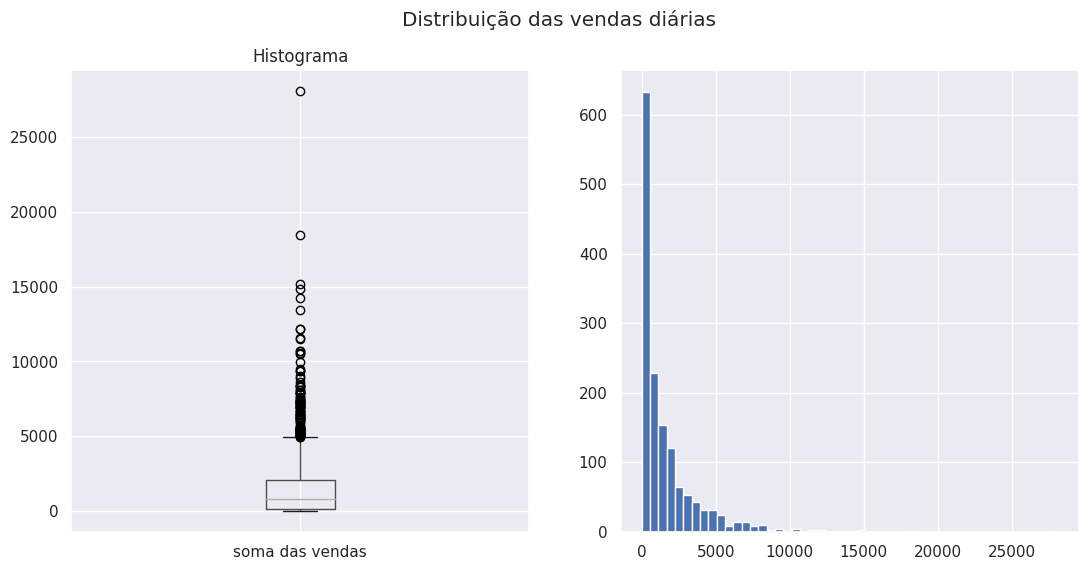

In [82]:
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(13,6))

fig.suptitle('Distribuição das vendas diárias')

df_ml.boxplot('soma das vendas', ax=ax1)
ax1.set_title('Boxplot')

ax2.hist(df_ml['soma das vendas'], bins=50)
ax1.set_title('Histograma')

plt.show()

Considerando que remover esses outliers causaria problemas (já que para prever uma série temporal geralmente se usa dias anteriores à data que se quer prever) substituiremos os outliers por um valor máximo.

O motivo de ter sido escolhido um valor máximo é porque queremos que o nosso modelo seja capaz de prever os picos de vendas, mas não queremos perder muita precisão nos pontos que não são picos. Se os outliers fossem substituídos pela média ou mediana, por exemplo, acabaríamos removendo grande parte de nossos máximos locais de vendas, principalmente no ano de 2018 onde temos os maiores valores. Ao mesmo tempo, se mantivermos os outliers de valor muito alto, acabaríamos perdendo precisão em 99% dos casos para tentar aprender um caso muito específico. Logo, utilizar um valor máximo permite o modelo a aprender picos de venda sem prejudicar muito o outros casos. Sobretudo, é importante ressaltar que a escolha desse valor para substituição faz com que o modelo não consiga prever fielmente valores acima do máximo.

Geralmente se escolhe o valor de $Q3+1,5\times IQR$ , onde $Q3$ é o terceiro quartil e o intervalo interquartil é $IQR=Q3-Q1$ . Porém, como nossa distribuição é assimétrica, foi escolhido $Q3+3× IQR$ a fim de perder menos pontos do dataset original.

In [83]:
Q1 = df_ml['soma das vendas'].quantile(0.25)
Q3 = df_ml['soma das vendas'].quantile(0.75)
IQR = Q3 - Q1
upper_whisker = Q3 + 3*IQR
print('Valor máximo para não ser considerado outlier: ', upper_whisker)

Valor máximo para não ser considerado outlier:  7814.445000000001


Se olharmos novamente para o boxplot, 7814,44 ainda é um número aceitável para incluir no nosso modelo, já que ainda temos uma quantidade considerável de pontos próximos a ele. Isso significa que os pontos logo abaixo de 7814,44 não serão pontos isolados e o modelo terá oportunidade de aprendê-los.

Agora que escolhemos o critério e o valor a substituir podemos tratar os outliers.

In [84]:
print('Valor máximo antes do tratamento: ', df_ml['soma das vendas'].max())

# Nova cópia do dataframe de machine learning para remover os outliers
df_mlo = df_ml.copy()   

df_mlo.loc[df_mlo['soma das vendas'] > upper_whisker, 'soma das vendas'] = upper_whisker

print('Valor máximo depois do tratamento: ', df_mlo['soma das vendas'].max())

Valor máximo antes do tratamento:  28106.716
Valor máximo depois do tratamento:  7814.445000000001


Antes de passar para o próximo passo, é importante ressaltar que o método utilizado acaba resultando em data leakage. Como aplicamos ele antes de separar o dataframe em treino e teste, acabamos por passar informação (medidas de $Q1$, $Q3$ e $IQR$) do segmento de treino para o de teste. Ou seja, a partição de teste cumprirá seu papel de representar dados não vistos na parte de treino.  

Acredita-se que este erro não afetará significativamente a veracidade das medidas de desempenho do modelo, já que os pontos substituídos representam um percentual baixo do número de linhas do dataframe, como pode ser visto abaixo. 

In [85]:
linhas = df_ml.shape[0]
linhas_sub = (df_ml['soma das vendas'] > upper_whisker).value_counts()[True]

print('Número de linhas do dataframe:', linhas)
print('Número de linhas substituídas:', linhas_sub)
print('Nercentual de substuição: {:.2f}%'.format(100*linhas_sub/linhas))

Número de linhas do dataframe: 1458
Número de linhas substituídas: 32
Nercentual de substuição: 2.19%


---
## 4.4 - Colunas de *lag*

Em modelos de série temporal é comum introduzir um atributo que consiste no atributo alvo deslocado no tempo. No nosso caso, introduzir *lag* consiste em introduzir colunas de soma das vendas dos dias passados.

Em relação ao número de períodos a ser utilizado, deve-se considerar que quanto maior o número de colunas adicionadas, maior a perda de informação original do dataset. Para passar o dataframe para o modelo, não podemos ter valores nulos em nenhuma coluna. Quando introduzimos colunas de *lag*, perdemos $n$ linhas onde $n$ é o período de *lag* mais antigo utilizado. Ou seja, se utilizarmos períodos muito antigos de *lag*, perdemos muitas observações no início do período estudado.

Para ajudar na escolha do número de lags, será utilizada uma função que plota a correlação da variável no tempo que queremos prever (t) com a variável deslocada no tempo em x períodos (t-x).

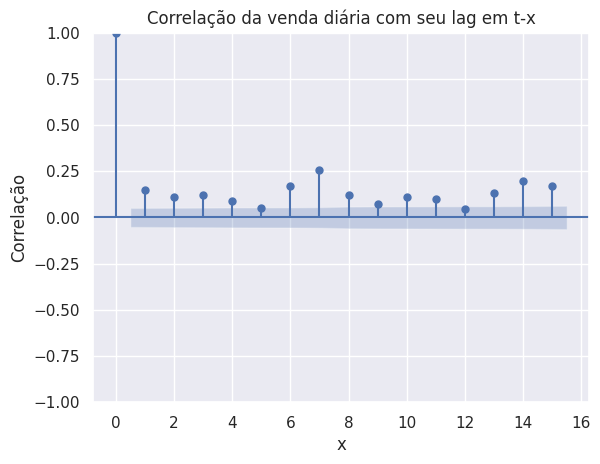

In [86]:
# Plota a função de autocorrelação
plot_acf(df_mlo['soma das vendas'], lags=15,
         title='Correlação da venda diária com seu lag em t-x')

plt.ylabel('Correlação')
plt.xlabel('x')
plt.show()

Podemos ver que, apesar de os valores serem baixos, a correlação aumenta em t=6 e t=7. Isso significa que existe uma tendência dos valores das vendas terem relação com o valor das vendas de dias da semana próximos da semana anterior. Esse comportamento cíclico corrobora o que foi observado na análise exploratória quando estudávamos a variação das vendas diárias a cada dia da semana. Da mesma forma, observa-se um aumento em t=13 e t=14 pelo mesmo motivo.

Supondo que os aumentos em t=13 e t=14 sejam devidos ao mesmo motivo de t=6 e t=7, colocar ambos os pares seria uma redundância. Por isso, se escolhe o t máximo de 7. Apesar dos valores de correlação baixos entre t=1 e t=5, é comum utilizar todos os períodos entre t=0 e t máximo, ao menos em modelos simples e com t máximo pequenos. Logo, serão utilizados os períodos de t=1..7.

In [87]:
# Cria um novo dataframe que será o dataframe de machine learning sem outliers
# e com a adição de colunas de lag
df_mlol = df_mlo.copy()

# Cria 7 colunas de vendas deslocadas cada vez de uma linha a mais
for t in range(1,8):
  df_mlol['vendas_t-' + str(t)] = df_mlol['soma das vendas'].shift(t)

df_mlol

,Is Holiday,soma das vendas,Month,Year,Day,day_of_week_sin,day_of_week_cos,vendas_t-1,vendas_t-2,vendas_t-3,vendas_t-4,vendas_t-5,vendas_t-6,vendas_t-7
Order Date,,,,,,,,,,,,,,
2015-01-03,False,16.4480,1,2015,3,-0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,False,288.0600,1,2015,4,-0.781831,0.623490,16.4480,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,False,19.5360,1,2015,5,0.000000,1.000000,288.0600,16.4480,NaN,NaN,NaN,NaN,NaN
2015-01-06,False,4407.1000,1,2015,6,0.781831,0.623490,19.5360,288.0600,16.448,NaN,NaN,NaN,NaN
2015-01-07,False,87.1580,1,2015,7,0.974928,-0.222521,4407.1000,19.5360,288.060,16.448,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-26,False,814.5940,12,2018,26,0.974928,-0.222521,2698.9270,6233.0540,1926.776,7442.021,2140.940,377.736,1895.926
2018-12-27,False,177.6360,12,2018,27,0.433884,-0.900969,814.5940,2698.9270,6233.054,1926.776,7442.021,2140.940,377.736
2018-12-28,False,1657.3508,12,2018,28,-0.433884,-0.900969,177.6360,814.5940,2698.927,6233.054,1926.776,7442.021,2140.940


Como foi dito anteriormente, temos que eliminar os valores faltantes nas linhas iniciais que resultam da introdução de *lag*.

In [88]:
df_mlol.dropna(how='any', inplace=True)
df_mlol.head()

,Is Holiday,soma das vendas,Month,Year,Day,day_of_week_sin,day_of_week_cos,vendas_t-1,vendas_t-2,vendas_t-3,vendas_t-4,vendas_t-5,vendas_t-6,vendas_t-7
Order Date,,,,,,,,,,,,,,
2015-01-10,False,54.830,1,2015,10,-0.974928,-0.222521,40.544,0.000,87.158,4407.100,19.536,288.060,16.448
2015-01-11,False,9.940,1,2015,11,-0.781831,0.623490,54.830,40.544,0.000,87.158,4407.100,19.536,288.060
2015-01-12,False,0.000,1,2015,12,0.000000,1.000000,9.940,54.830,40.544,0.000,87.158,4407.100,19.536
2015-01-13,False,3553.795,1,2015,13,0.781831,0.623490,0.000,9.940,54.830,40.544,0.000,87.158,4407.100
2015-01-14,False,61.960,1,2015,14,0.974928,-0.222521,3553.795,0.000,9.940,54.830,40.544,0.000,87.158


---
## 4.5 Separação em treino e teste

A separação em treino e teste deve ser feita antes da normalização para evitar data leakage. Utilizaremos 80% do dataset para treino e 20% para teste.

In [89]:
y = df_mlol['soma das vendas']
y = y.values
x = df_mlol.drop('soma das vendas', axis=1)
x = x.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=0)

Verificando como ficaram nossos dados:

In [90]:
x_train

array([[False, 6, 2016, ..., 3443.904, 734.144, 51.072],
       [False, 7, 2015, ..., 0.0, 265.521, 763.0740000000001],
       [False, 6, 2015, ..., 491.55, 5463.008, 2501.264],
       ...,
       [False, 5, 2018, ..., 185.123, 1146.2450000000001, 1386.346],
       [False, 7, 2016, ..., 448.082, 3029.386, 0.0],
       [True, 11, 2016, ..., 1040.784, 0.0, 3885.986]], dtype=object)

In [91]:
y_train

array([ 107.976,    9.51 ,  942.974, ...,    0.   ,    0.   , 1218.764])

---
## 4.6 - Normalização

Agora que temos nosso dataframe particionado, podemos ajustar os valores da normalização com os dados de treino e aplicar nas partições de treino e de teste.

In [92]:
scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Verificando como ficaram nossos dados normalizados:

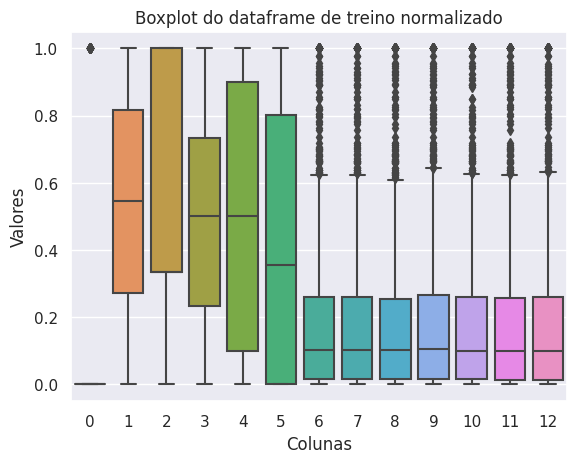

In [93]:
sns.boxplot(data=x_train_scaled)

plt.title('Boxplot do dataframe de treino normalizado')
plt.xlabel('Colunas')
plt.ylabel('Valores')
plt.show()

Valor da coluna booleana de feriado igual a 0 ou 1 e valores de todas as outras colunas entre 0 e 1, conforme o esperado.

---
## 4.7 - O que mais poderia ser feito

O objetivo deste MVP já foi alcançado. Porém, é interessante destacar alguns pontos de modificações ou etapas adicionais de pré-processamento que poderiam ser feitas a fim de se estudar como essas mudanças afetariam a acurácia do modelo.

*   Discretizar os valores de vendas diárias, transformando em uma variável categória ordinal.
*   Testar valores diferentes para substituição de outliers.
*   Adicionar *lag* nos dias de feriado, a fim de verificar se a presença de feriado em um dia afeta dias futuros.
*   Testar períodos de *lag* diferentes
*   Aplicar o encoding trigonométrico nas colunas de dia e mês, já que estas também apresentam cíclos
*   Remover as colunas de data (dia, mês e ano), já que alguns autores consideram que o modelo deve aprender a sazonalidade e tendências não-estacionárias sem acesso a esses atributos

---
# <center>5 - Conclusão
---


Neste notebook foi feito o pré-processamento e análise dos dados de uma empresa de venda de produtos dos Estados Unidos. Como o foco é o estudo e a previsão das vendas diárias, foi analisada principalmente a distribuição das vendas ao longo do tempo. No final, os dados agrupados por dia foram tratados para uma futura implementação de aprendizado de máquina supervisionado, onde o modelo irá prever os valores diários de vendas até 7 dias no futuro.

Os principais comportamentos evidenciados pela análise exploratória foram:

*   O dataset contém 4922 pedidos espalhados ao longo de 4 anos.
*   A maioria dos itens vendidos consiste em material de escritório relacionado a papéis e grampeadores.
*   Apesar da maioria dos itens vendidos consistirem em material de escritório, a soma das vendas é quase igualmente distribuído em material de escritório, mobília e tecnologia.
*   O estado com mais vendas é a Califórnia, mas a cidade com mais vendas é New York City.
*   Existe uma clara tendência cíclica nas vendas, com uma concentração maior no final do ano e entre sábado e terça-feira.
*   O volume de vendas é praticamente igual em feriados e dias normais.
*   Existe uma grande variação no valor diário das vendas, o que pode prejudicar a acurácia do modelo.
*   É mais fácil visualizar as tendências em gráficos de vendas agrupadas por semana e mês, devido à variação citada acima.
*   As vendas de 2015 e 2016 foram quase as mesmas, mas houve um aumento significativo tanto em 2017 quanto em 2018. Além disso, o final do ano de 2018 mostrou um crescimento ainda maior.
*   As vendas de produtos de tecnologia foram consideravelmente maiores que os outros tipos em 2018. Além disso, a evolução das compras indica que os produtos de mobília se tornarão cada vez menos relevantes para a empresa.
*   Aparentemente, existe um problema que está afetando algumas entregas de tipo 'mesmo dia'. Este problema é mais evidente nos anos de 2017 e 2018, especificamente na região oeste.

Foi recomendado avaliar a mudança dos requisitos funcionais do modelo para prever vendas semanais ou mensais, ao invés de diárias. Acredita-se que a acurácia seria consideravelmente melhor se os dados fossem agrupados por mês.

No final do MVP, foi feito o pré-processamento para o modelo de *machine learning* supervisionado a ser implementado no futuro. Foi adicionado um encoding trigonométrico para os dias da semana, tratados os outliers e adicionadas as colunas de *lag* de vendas de dias anteriores. Por fim, o dataframe foi normalizado após ser particionado em treino e teste.

Para finalizar, devido à limitação de tempo e escopo do MVP, existem três ideias que não foram implementadas que podem servir para trabalhos futuros:

1.   Implementação das etapas de pré-processamentos adicionais citadas em 4.7.
2.   Pré-processar e comparar os modelos de vendas semanais e mensais com o modelo de vendas diárias.
3.   Utilizar o dataframe original `df` para o problema de aprendizado de máquina não supervisionado de associação para a recomendação de produtos.

---
---
